# Исследование показателей приложения Procrastinate Pro+

**Цель проекта**


Исследование проводится по причине убыточности приложения, несмотря на значительный рекламный бюджет в последние месяцы. Главной задачей анализа является формулирование рекомендаций для рекламного отдела с опорой на фактические данные.

**Исходные данные**


Предоставленные исходные данные: файлы в формате `.csv` с информацией о визитах и платежах пользователей, а также о рекламных расходах компании.

Исследование проведено по состоянию на **01.11.2019**, горизонт анализа -- **две недели** (согласно БП) 

## План работ

- Чтение и первичный анализ массива данных, импорт библиотек
- Предобработка данных
    - Пропуски
    - Типы данных
    - Неявные/явные дубликаты
    - Аномальные значения
    - Вывод по предобработке
- Объявление функций для расчета и визуализации метрик юнит-экономики
- Исследовательский анализ данных
    - Составление профилей пользователей, минимальная и максимальная даты привлечения
        - выводы
    - Анализ пользователей:
        - по регионам
            - выводы
        - по устройствам
            - выводы
        - по каналам привлечения трафика
            - выводы
    - Вывод к исследовательскому анализу
- Анализ маркетинга
    - Общая сумма расходов
    - Распределение трат по источникам трафика
    - Динамика расходов по источникам
    - Расчет CAC по источникам
    - Промежуточные выводы
- Оценка рентабельности рекламы
    - Анализ `LTV` и `ROI`, а также их динамик в целом
    - Рассмотрение `CR` и `RR`, а также их динамик
    - Кластеризация `LTV` и `ROI`:
        - по регионам
        - по устройствам
        - по каналам привлечения трафика
    - Промежуточные выводы
- Общий вывод
    - Причины неэффективности стратегии маркетинга
    - Рекомендации

## Чтение данных и импорт библиотек

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# other
import numpy as np
from datetime import datetime, timedelta

In [2]:
# reading from local files
visits = pd.read_csv('/Users/ilatti/Documents/practicum/7_sprint/project/visits_info_short.csv')
orders = pd.read_csv('/Users/ilatti/Documents/practicum/7_sprint/project/orders_info_short.csv')
costs = pd.read_csv('/Users/ilatti/Documents/practicum/7_sprint/project/costs_info_short.csv')

In [3]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [5]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom 113.30
1  2019-05-02  FaceBoom  78.10
2  2019-05-03  FaceBoom  85.80
3  2019-05-04  FaceBoom 136.40
4  2019-05-05  FaceBoom 122.10

**Вывод**
- Самый большой датафрейм с сессиями -- в нем 310 тыс. записей;
- Названия столбцов следует отредактировать для удобства;
- Пропусков в данных нет;
- Следует проверить данные на дубликаты и аномальные значения.

## Предобработка данных

### Форматирование текста

Отформатируем названия столбцов однообразно:

In [6]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns =  costs.columns.str.lower().str.replace(' ', '_')

In [7]:
visits.head()

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [8]:
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [9]:
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom 113.30
1  2019-05-02  FaceBoom  78.10
2  2019-05-03  FaceBoom  85.80
3  2019-05-04  FaceBoom 136.40
4  2019-05-05  FaceBoom 122.10

Также для удобства работы и облегчения поиска неявных дубликатов отформатируем все текстовые поля однообразно

In [10]:
visits.region = visits.region.str.lower().str.replace(' ', '_')
visits.device = visits.device.str.lower().str.replace(' ', '_')
visits.channel = visits.channel.str.lower().str.replace(' ', '_')
visits.head()

user_id         region   device  channel        session_start  \
0  981449118918  united_states   iphone  organic  2019-05-01 02:36:01   
1  278965908054  united_states   iphone  organic  2019-05-01 04:46:31   
2  590706206550  united_states      mac  organic  2019-05-01 14:09:25   
3  326433527971  united_states  android   tiptop  2019-05-01 00:29:59   
4  349773784594  united_states      mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [11]:
costs.channel = costs.channel.str.lower().str.replace(' ', '_')
costs.head()

dt   channel  costs
0  2019-05-01  faceboom 113.30
1  2019-05-02  faceboom  78.10
2  2019-05-03  faceboom  85.80
3  2019-05-04  faceboom 136.40
4  2019-05-05  faceboom 122.10

### Типы данных

Приведем все поля с датами к типу `datetime`

In [12]:
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_end)
orders.event_dt = pd.to_datetime(orders.event_dt)
costs.dt = pd.to_datetime(costs.dt).dt.date

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Типы данных корректны

### Дубликаты

In [16]:
visits.region.unique()

array(['united_states', 'uk', 'france', 'germany'], dtype=object)

In [17]:
visits.device.unique()

array(['iphone', 'mac', 'android', 'pc'], dtype=object)

In [18]:
visits.channel.sort_values().unique()

array(['adnonsense', 'faceboom', 'lambdamediaads', 'leapbob',
       'mediatornado', 'opplecreativemedia', 'organic', 'rocketsuperads',
       'tiptop', 'wahoonetbanner', 'yrabbit'], dtype=object)

In [19]:
costs.channel.sort_values().unique()

array(['adnonsense', 'faceboom', 'lambdamediaads', 'leapbob',
       'mediatornado', 'opplecreativemedia', 'rocketsuperads', 'tiptop',
       'wahoonetbanner', 'yrabbit'], dtype=object)

Неявных дубликатов в категориальных переменных не выявлено, источники трафика совпадают для архива сессий и данных по тратам (органики нет в затратах, логично)

Поищем явные полные дубликаты в данных

In [20]:
visits.duplicated().sum()

0

In [21]:
orders.duplicated().sum()

0

In [22]:
costs.duplicated().sum()

0

Полных дубликатов не выявлено, попробуем поискать дубликаты в группе столбцов `visits`

In [23]:
visits['check'] = (visits.user_id.apply(str) 
                   + visits.session_start.apply(str) 
                   + visits[['region','device','channel']].sum(axis = 1))
visits.head()

user_id         region   device  channel       session_start  \
0  981449118918  united_states   iphone  organic 2019-05-01 02:36:01   
1  278965908054  united_states   iphone  organic 2019-05-01 04:46:31   
2  590706206550  united_states      mac  organic 2019-05-01 14:09:25   
3  326433527971  united_states  android   tiptop 2019-05-01 00:29:59   
4  349773784594  united_states      mac  organic 2019-05-01 03:33:35   

          session_end                                              check  
0 2019-05-01 02:45:01  9814491189182019-05-01 02:36:01united_statesip...  
1 2019-05-01 04:47:35  2789659080542019-05-01 04:46:31united_statesip...  
2 2019-05-01 15:32:08  5907062065502019-05-01 14:09:25united_statesma...  
3 2019-05-01 00:54:25  3264335279712019-05-01 00:29:59united_statesan...  
4 2019-05-01 03:57:40  3497737845942019-05-01 03:33:35united_statesma...

In [24]:
visits.duplicated(subset='check').sum()

0

In [25]:
visits = visits.drop(columns='check')
visits.head()

user_id         region   device  channel       session_start  \
0  981449118918  united_states   iphone  organic 2019-05-01 02:36:01   
1  278965908054  united_states   iphone  organic 2019-05-01 04:46:31   
2  590706206550  united_states      mac  organic 2019-05-01 14:09:25   
3  326433527971  united_states  android   tiptop 2019-05-01 00:29:59   
4  349773784594  united_states      mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

Работа с дубликатами проведена, дубликатов не выявлено

### Аномальные значения

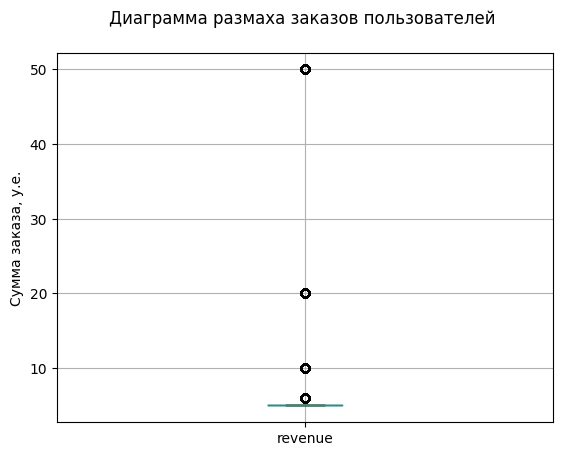

count   40,212.00
mean         5.37
std          3.45
min          4.99
25%          4.99
50%          4.99
75%          4.99
max         49.99
Name: revenue, dtype: float64

In [26]:
orders.boxplot(column='revenue');
plt.title('Диаграмма размаха заказов пользователей \n')
plt.ylabel('Сумма заказа, у.е.')
plt.show()

orders.revenue.describe()

In [27]:
orders.revenue.value_counts() / orders.shape[0] * 100

4.99    96.07
5.99     1.94
9.99     0.96
49.99    0.53
19.99    0.51
Name: revenue, dtype: float64

Значения трат пользователей дискретны -- скорее всего, это месячная подписка

In [28]:
orders.groupby('user_id').agg({'revenue':['min', 'max', 'mean', 'count']}).head()

revenue                 
              min   max mean count
user_id                           
599326       4.99  4.99 4.99     3
46006712     4.99  4.99 4.99     1
374052872    4.99  4.99 4.99     8
414791703    4.99  4.99 4.99    10
785077127    4.99 49.99 9.08    11

In [29]:
orders.query('user_id == 785077127')

user_id            event_dt  revenue
5537   785077127 2019-06-30 18:35:15     4.99
6173   785077127 2019-07-04 11:10:57     4.99
6616   785077127 2019-07-07 22:59:55     4.99
7591   785077127 2019-07-13 11:52:40     4.99
8450   785077127 2019-07-19 18:45:57     4.99
11425  785077127 2019-08-08 22:50:25     4.99
15515  785077127 2019-09-01 00:52:52     4.99
15896  785077127 2019-09-03 15:39:51     4.99
19585  785077127 2019-09-23 16:03:56     4.99
20622  785077127 2019-09-28 08:54:05    49.99
21070  785077127 2019-09-30 00:32:03     4.99

Гипотеза не подтвердилась, траты не раз в месяц, это некие платные действия; оставляем значения как есть

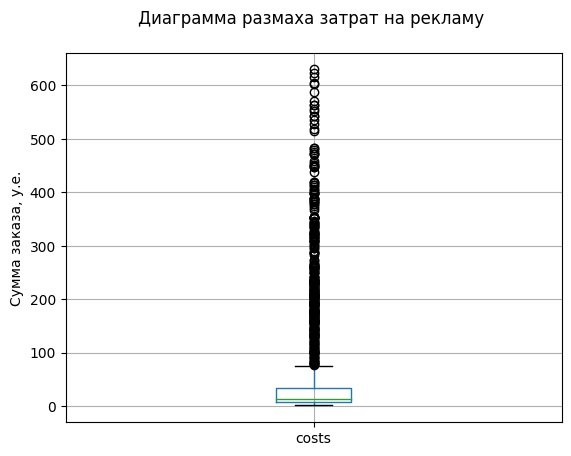

count   1,800.00
mean       58.61
std       107.74
min         0.80
25%         6.50
50%        12.29
75%        33.60
max       630.00
Name: costs, dtype: float64

In [30]:
costs.boxplot(column='costs');
plt.title('Диаграмма размаха затрат на рекламу \n')
plt.ylabel('Сумма заказа, у.е.')
plt.show()

costs.costs.describe()

- Распределение трат на рекламу сильно смещено вправо, многие значения выбиваются за третий квартиль;
- Такое распределение объяснимо: каждая трата пропорциональна объему привлеченного трафика;
- Проанализируем траты подробнее позже: необходимо соотнести их с количеством трафика и рассчитать `CAC`

### **Вывод**

- Названия столбцов и текстовые поля приведены к нижнему регистру, пробелы заменены на нижнее подчеркивание;
- Пропусков данных не обнаружено;
- Типы данных для столбцов с датой приведены в соответствие;
- Дубликаты всех видов не обнаружены;
- Аномальные значения не обнаружены.


## Функции для работы с метриками

### Создание пользовательских профилей

In [31]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Расчёт удержания

In [32]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Расчёт конверсии

In [33]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Расчёт `LTV` и `ROI`

In [34]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Сглаживание фрейма

In [35]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Визуализация удержания

In [36]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Визуализация конверсии

In [37]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Визуализация `LTV` и `ROI`

In [38]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

### Профили пользователей

Применим функцию:

In [39]:
events=None
profiles = get_profiles(visits, orders, events, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    faceboom     mac  united_states   
1   4919697 2019-07-09 12:46:07    faceboom  iphone  united_states   
2   6085896 2019-10-01 09:58:33     organic  iphone         france   
3  22593348 2019-08-22 21:35:48  adnonsense      pc        germany   
4  31989216 2019-10-02 00:07:44     yrabbit  iphone  united_states   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True              1.09  
1  2019-07-09 2019-07-01  False              1.11  
2  2019-10-01 2019-10-01  False              0.00  
3  2019-08-22 2019-08-01  False              0.99  
4  2019-10-02 2019-10-01  False              0.23

In [40]:
print(f'Минимальная дата привлечения пользователя: {profiles.dt.min()}')
print(f'Максимальная дата привлечения пользователя: {profiles.dt.max()}')

Минимальная дата привлечения пользователя: 2019-05-01
Максимальная дата привлечения пользователя: 2019-10-27


In [41]:
profiles.user_id.count()

150008

**Вывод**
- Всего было привлечено 150 тыс. пользователей;
- Минимальная и максимальная даты в профилях соответствуют временному промежутку, описанному в условии. 

### Анализ регионов пользователей

In [42]:
(
    profiles.groupby('region')
    .agg(
            payers=('payer', 'sum'),
            users=('user_id', 'count'),
            p_u_ratio=('payer', 'mean'),
        )
    .sort_values(by='p_u_ratio', ascending=False)
    .style.format("{:,.3f}")
)

**Вывод**
- Приложение используют в четырех странах: США, Великобритания, Франция и Германия;
- Больше всего привлечено пользователей из США: всего было привлечено 100 тыс. пользователей, при этом в оставшихся трех странах количество привлеченных пользователей от 15 до 18 тыс;
- В лидерах по количеству платящих пользователей США, как и по соотношению платящих пользователей ко всем.


### Анализ устройств пользователей

In [43]:
(
    profiles.groupby('device')
    .agg(
            payers=('payer', 'sum'),
            users=('user_id', 'count'),
            p_u_ratio=('payer', 'mean'),
        )
    .sort_values(by='p_u_ratio', ascending=False)
    .style.format("{:,.3f}")
)

**Вывод**
- Приложением пользуются на четырех платформах: `iphone`, `android`, `mac` и `pc`;
- Больше всего привлечено пользователей `iphone`;
- Лидером по количеству платящих пользователей также является `iphone`, однако, доля платящих пользователей для `mac` несколько выше.

### Анализ источников трафика

In [44]:
channel_CR = (
    profiles.groupby('channel')
    .agg(
            payers=('payer', 'sum'),
            users=('user_id', 'count'),
            p_u_ratio=('payer', 'mean'),
        )
    .sort_values(by='p_u_ratio', ascending=False)
)
channel_CR

payers  users  p_u_ratio
channel                                     
faceboom              3557  29144       0.12
adnonsense             440   3880       0.11
lambdamediaads         225   2149       0.10
tiptop                1878  19561       0.10
rocketsuperads         352   4448       0.08
wahoonetbanner         453   8553       0.05
yrabbit                165   4312       0.04
mediatornado           156   4364       0.04
leapbob                262   8553       0.03
opplecreativemedia     233   8605       0.03
organic               1160  56439       0.02

**Вывод**
- За анализируемый период самый популярный способ привлечения в приложения -- органический;
- При этом больше всего платящих пользователей в абсолютном выражении привлечено по источнику `faceboom`.

### **Вывод**

- Привлеченные пользователи живут в США, Великобритании, Франции и Германии, самые качественные пользователи из США; наименее качественные из Франции;
- Всего в выборке четыре типа устройств, с которых заходили в приложение: `iphone`, `android`, `mac` и `pc`, в абсолютном выражении у самых качественных пользователей `iphone`, а в относительном -- `mac`, наименее качественные пользователи `pc`;
- Больше всего пользователей привлечены в приложение органически, при этом у органиков самая низкая доля платящих пользователей; наиболее качественных пользователей привлек источник `faceboom`.    

## Анализ маркетинга

Найдем общую сумму затрат на маркетинг

In [45]:
marketing_total_exp = round(costs.costs.sum())
print(f'Общие затраты на маркетинг за рассматриваемый период {marketing_total_exp} у.е.')

Общие затраты на маркетинг за рассматриваемый период 105497 у.е.


In [46]:
marketing_channel_exp = (
    costs.groupby('channel')['costs']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
marketing_channel_exp.columns=['channel', 'total_expenses']
marketing_channel_exp = marketing_channel_exp.merge(channel_CR, on='channel', how='left')
pd.options.display.float_format = '{:,.3f}'.format
marketing_channel_exp.sort_values(by='p_u_ratio', ascending=False)

channel  total_expenses  payers  users  p_u_ratio
1            faceboom      32,445.600    3557  29144      0.122
3          adnonsense       3,911.250     440   3880      0.113
7      lambdamediaads       1,557.600     225   2149      0.105
0              tiptop      54,751.300    1878  19561      0.096
5      rocketsuperads       1,833.000     352   4448      0.079
2      wahoonetbanner       5,151.000     453   8553      0.053
9             yrabbit         944.220     165   4312      0.038
8        mediatornado         954.480     156   4364      0.036
6             leapbob       1,797.600     262   8553      0.031
4  opplecreativemedia       2,151.250     233   8605      0.027

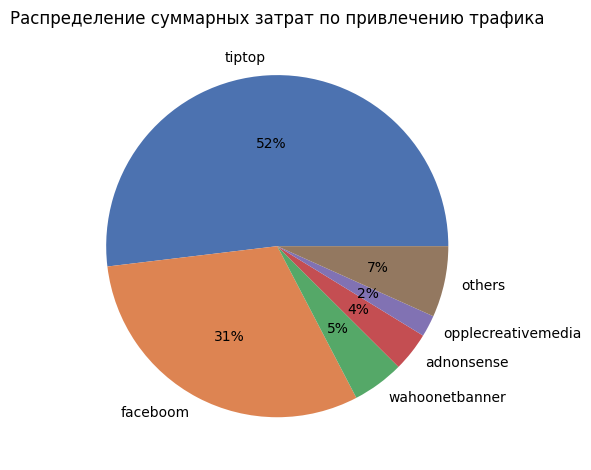

In [47]:
source_vs_exp = (marketing_channel_exp
                 .groupby('channel', as_index=False)['total_expenses']
                 .sum()
                 .sort_values(by='total_expenses', 
                              ascending=False)
                 .reset_index(drop=True))

other_channels = source_vs_exp.loc[5:, 'total_expenses'].sum()
source_vs_exp = source_vs_exp.loc[:4, :]
source_vs_exp.loc[5, 'channel'] = 'others'
source_vs_exp.loc[5, 'total_expenses'] = other_channels


fig, ax = plt.subplots()
fig.set(tight_layout=True);
colors = sns.color_palette('deep')
ax.pie(source_vs_exp.total_expenses, labels=source_vs_exp.channel, colors=colors, autopct='%1.0f%%')
ax.set(ylabel=None, title='Распределение суммарных затрат по привлечению трафика')

plt.show()

Больше всего средств было потрачено на продвижение через `tiptop`, однако, историческая конверсия в этом источнике на четвертом месте

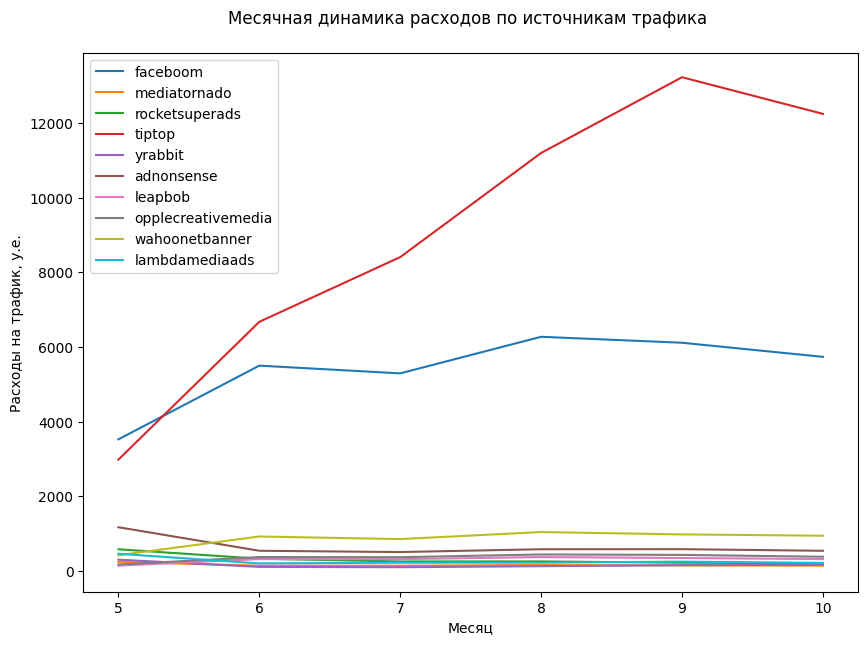

In [48]:
costs_fig = costs.copy()
costs_fig['month'] = pd.to_datetime(costs_fig['dt']).dt.month
costs_fig['week'] = pd.to_datetime(costs_fig['dt']).dt.isocalendar().week


fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

for i in costs_fig['channel'].unique():
    pivot_i = (costs_fig.query('channel == @i')
                 .pivot_table(index='month', 
                              values='costs', 
                              aggfunc='sum'))
    
    ax.plot(pivot_i.index, pivot_i['costs'], label = i)
    
ax.set_title('Месячная динамика расходов по источникам трафика \n')
ax.set_ylabel('Расходы на трафик, у.е.')
ax.set_xlabel('Месяц')
ax.legend()
plt.show;
plt.draw()
plt.pause(0.001)

Больше всего вкладывается денег в покупку трафика у `tiptop` и `faceboom`, при этом в `tiptop` вкладывается все больше и больше денег, а вливания в `faceboom` примерно на одном уровне с июля 2019

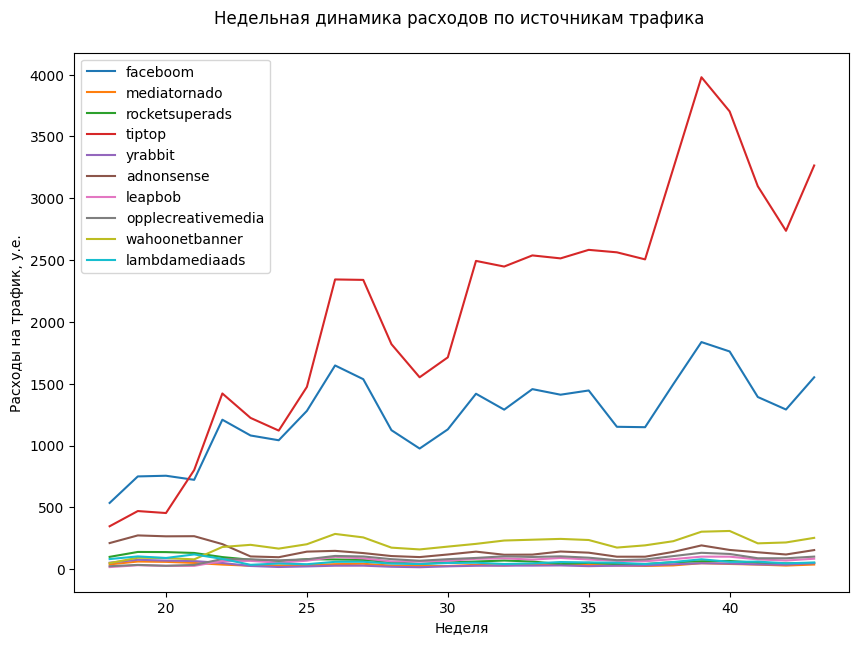

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

for i in costs_fig['channel'].unique():
    pivot_i = (costs_fig.query('channel == @i')
                 .pivot_table(index='week', 
                              values='costs', 
                              aggfunc='sum'))
    
    ax.plot(pivot_i.index, pivot_i['costs'], label = i)
    
ax.set_title('Недельная динамика расходов по источникам трафика \n')
ax.set_ylabel('Расходы на трафик, у.е.')
ax.set_xlabel('Неделя')
ax.legend()
plt.show;
plt.draw()
plt.pause(0.001)

Рассчитаем среднюю стоимость привлечения пользователя для разных источников трафика:

In [50]:
marketing_channel_exp['cac'] = marketing_channel_exp.total_expenses / marketing_channel_exp.users
marketing_channel_exp.sort_values(by='cac', ascending=False)

channel  total_expenses  payers  users  p_u_ratio   cac
0              tiptop      54,751.300    1878  19561      0.096 2.799
1            faceboom      32,445.600    3557  29144      0.122 1.113
3          adnonsense       3,911.250     440   3880      0.113 1.008
7      lambdamediaads       1,557.600     225   2149      0.105 0.725
2      wahoonetbanner       5,151.000     453   8553      0.053 0.602
5      rocketsuperads       1,833.000     352   4448      0.079 0.412
4  opplecreativemedia       2,151.250     233   8605      0.027 0.250
9             yrabbit         944.220     165   4312      0.038 0.219
8        mediatornado         954.480     156   4364      0.036 0.219
6             leapbob       1,797.600     262   8553      0.031 0.210

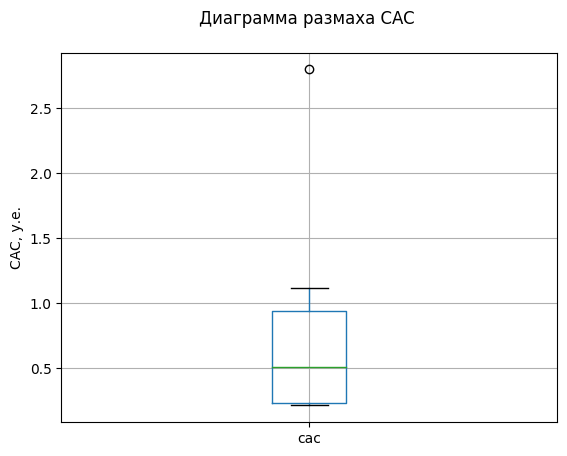

count   10.000
mean     0.756
std      0.792
min      0.210
25%      0.227
50%      0.507
75%      0.937
max      2.799
Name: cac, dtype: float64

In [51]:
marketing_channel_exp.boxplot(column='cac');
plt.title('Диаграмма размаха CAC \n')
plt.ylabel('CAC, у.е.')
plt.show()

marketing_channel_exp.cac.describe()

- Средняя стоимость привлечения одного пользователя через `tiptop` превышает этот же показатель у `faceboom` -- ближайшего конкурента по `CAC` более, чем в 2.5 раза
- Можно разделить источники трафика по стоимости привлечения клиента на основании статистического распределения: 


    - очень дешевые: `leapbob`, `mediatornado`, `yrabbit` 
    - дешевые: `opplecreativemedia` `rocketsuperads` 
    - дорогие: `wahoonetbanner` `lambdamediaads`
    - очень дорогие: `adnonsense` `faceboom`
    - неадекватно дорогие: `tiptop`

Введем критерий подобия: разделим историческую конверсию пользователей на исторический `CAC` и отсортируем источники трафика по этому критерию

In [52]:
marketing_channel_exp['cr_cac_ratio'] = marketing_channel_exp.p_u_ratio / marketing_channel_exp.cac
marketing_channel_exp.sort_values(by='cr_cac_ratio', ascending=False).reset_index().drop(columns='index')

channel  total_expenses  payers  users  p_u_ratio   cac  \
0      rocketsuperads       1,833.000     352   4448      0.079 0.412   
1             yrabbit         944.220     165   4312      0.038 0.219   
2        mediatornado         954.480     156   4364      0.036 0.219   
3             leapbob       1,797.600     262   8553      0.031 0.210   
4      lambdamediaads       1,557.600     225   2149      0.105 0.725   
5          adnonsense       3,911.250     440   3880      0.113 1.008   
6            faceboom      32,445.600    3557  29144      0.122 1.113   
7  opplecreativemedia       2,151.250     233   8605      0.027 0.250   
8      wahoonetbanner       5,151.000     453   8553      0.053 0.602   
9              tiptop      54,751.300    1878  19561      0.096 2.799   

   cr_cac_ratio  
0         0.192  
1         0.175  
2         0.163  
3         0.146  
4         0.144  
5         0.112  
6         0.110  
7         0.108  
8         0.088  
9         0.034

Следует рассмотреть показатель `ROI` и его динамику для более уверенных выводов, но на текущем этапе можно заметить, что исходя из исторической конверсии пользователей и исторической средней стоимости их привлечения, два источника трафика, в которых сосредоточено большинство маркетинговых трат -- `tiptop` и `faceboom`, не являются самыми эффективными из представленных

### **Вывод**
- За последние пять месяцев рекламный бюджет составил 106 тыс. у.е
- Примерно 83 % всего бюджета потрачено на два источника трафика -- `tiptop` и `faceboom`, при этом чуть больше половины всех средств ушло на продвижение через `tiptop`
- Траты на все источники трафика можно назвать примерно постоянными в сравнении с тратами на `tiptop` -- этот источник трафика демонстрирует стремительный рост затрат в течение рассматриваемого периода
- Наибольшая средняя стоимость привлечения одного пользователя у источников `tiptop` и `faceboom`, при это для `tiptop` этот показатель в 2.5 раза выше в сравнении с `faceboom`
- Наименьшая средняя стоимость привлечения одного пользователя у источников `leapbob`, `mediatornado` и `yrabbit`
- В рейтинге источников трафика по конверсии пользователей с учетом `CAC`, требуемого для привлечения этих пользователей, `tiptop` и `faceboom` находятся в худшей половине, `tiptop` находится на последнем месте
- Рекомендуется пересмотреть распределение рекламного бюджета -- вероятно, стоит сфокусироваться на других источниках трафика
- Необходимо уточнить: способны ли другие источники обеспечить необходимый приток пользователей?
- Для окончательных выводов необходимо рассмотреть `ROI` и его динамику

## Оценка рентабельности рекламы

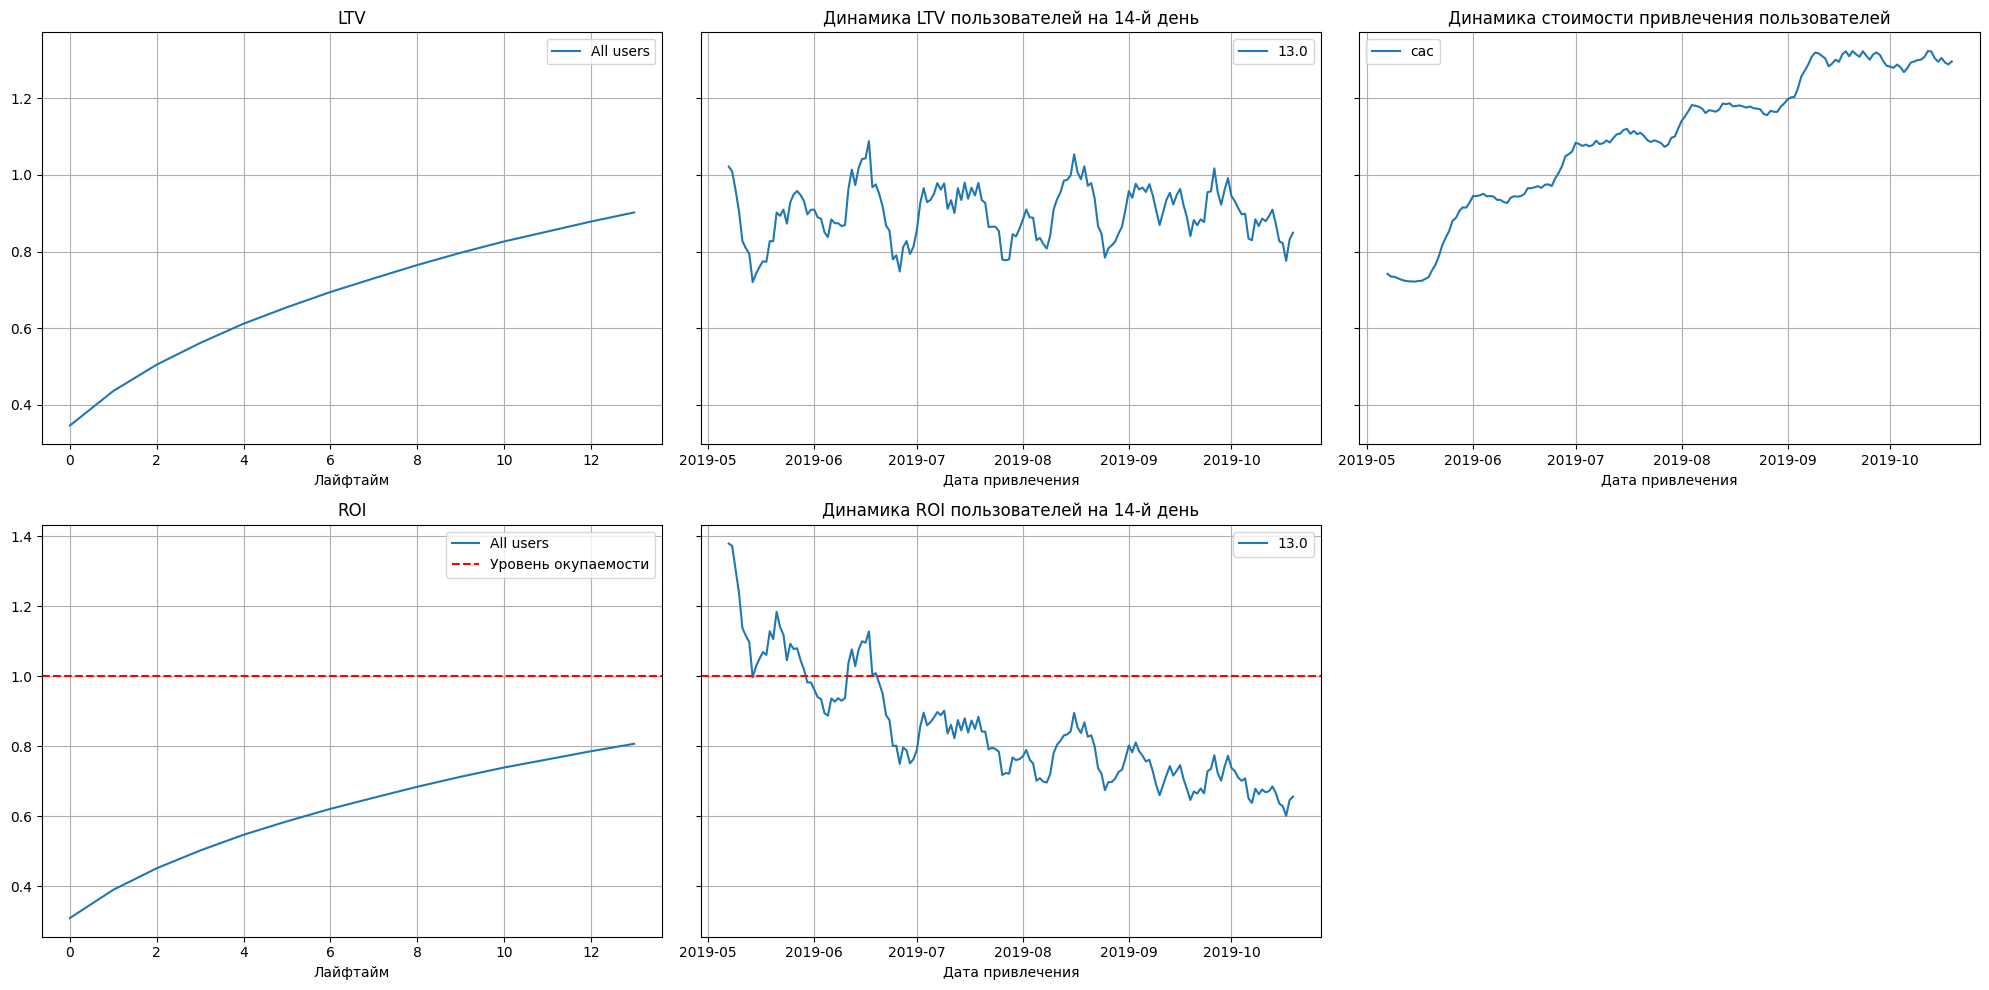

In [53]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

#исключим органических пользователей для ликвидации искажения общей картины
profiles_full = profiles.copy()
visits_full = visits.copy()

profiles = profiles.query('channel != "organic"')
visits = visits.query('channel != "organic"')

raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

- `LTV` постепенно растет и к концу второй недели достигает значения в ~ 0.9 у.е. на пользователя
- Динамика `LTV` двух недель демонстрирует сезонность, однако достаточно стабильна
- Динамика `CAC` демонстрирует резкий рост в конце мая-начале июня с последующим умеренным ростом -- вероятно, это связано с увеличением затрат на привлечение трафика из самого дорогого источника -- `tiptop`
- Показатель `ROI` постепенно растет и к концу второй недели едва пересекает отметку в `80 %` -- инвестиции в рекламу убыточны
- Динамика `ROI` двух недель показывает, что в мае маркетинговые инвестиции окупались, как и в середине июня, но тренд, намеченный в начале июня сохранился и продолжился с конца июня -- инвестиции стали убыточны; выход в плюс в середине июня объясняется сезонностью -- в этот период динамика `LTV` также демонстрирует рост

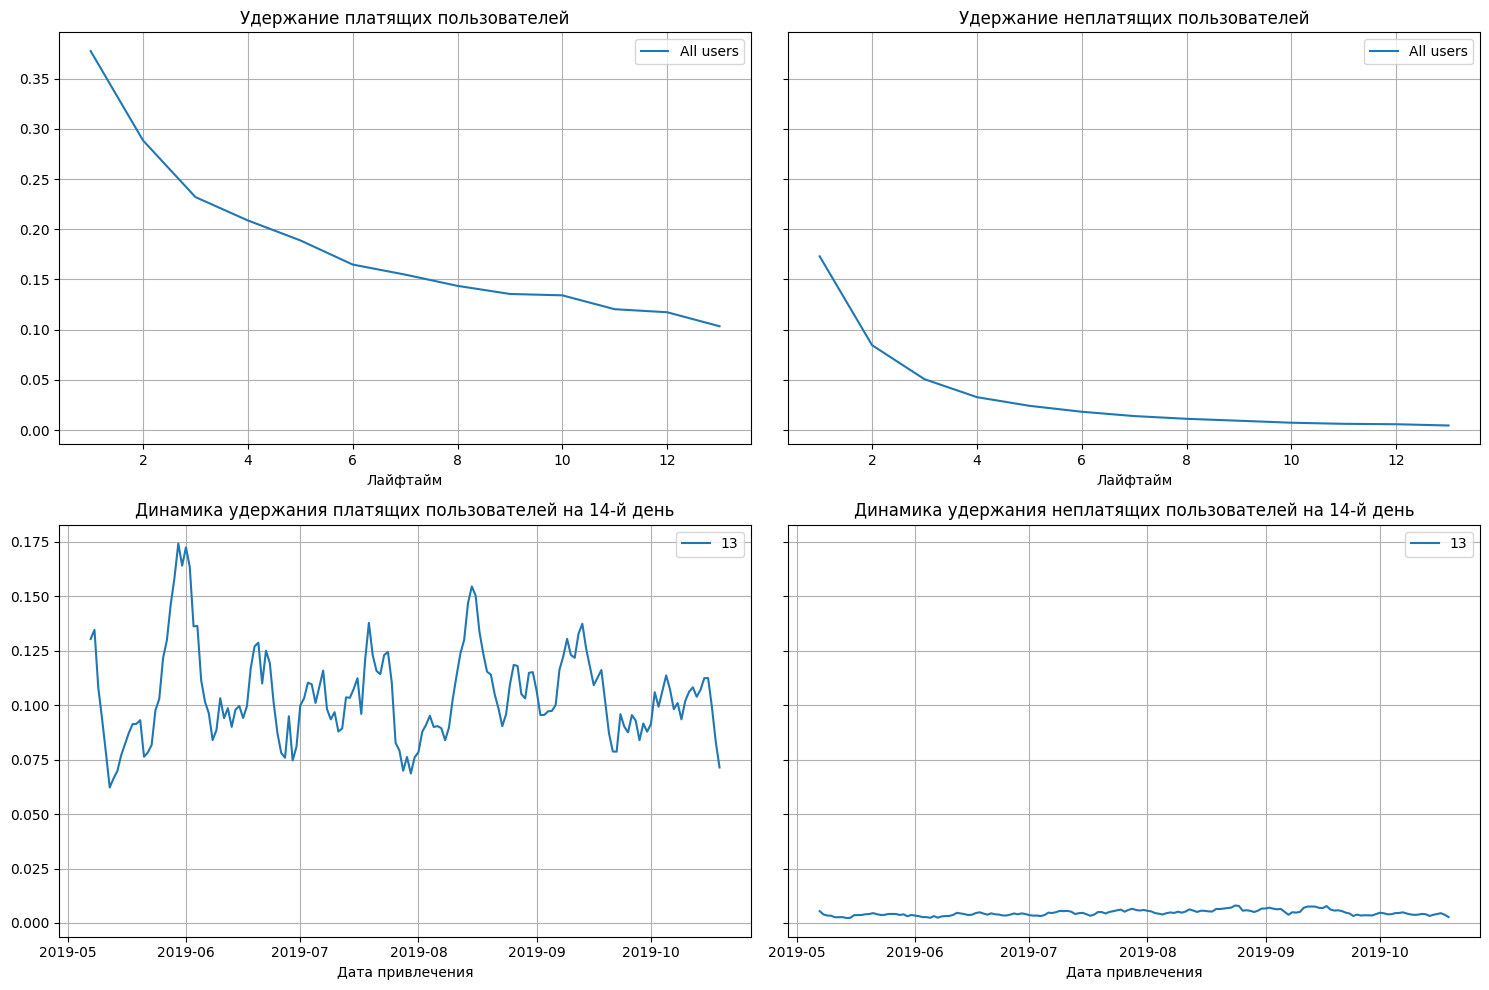

In [54]:
raw_ret, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_retention(retention, retention_history, horizon_days, window=7)

- График удержания имеет ожидаемый вид со снижением
- Ожидаемо, удержание платящих пользователей выше удержания неплатящих
- Динамика удержания двух недель для неплатящих пользователей стабильна, но этот же показатель для платящих пользователей показывает сильные колебания около значения `0.1`

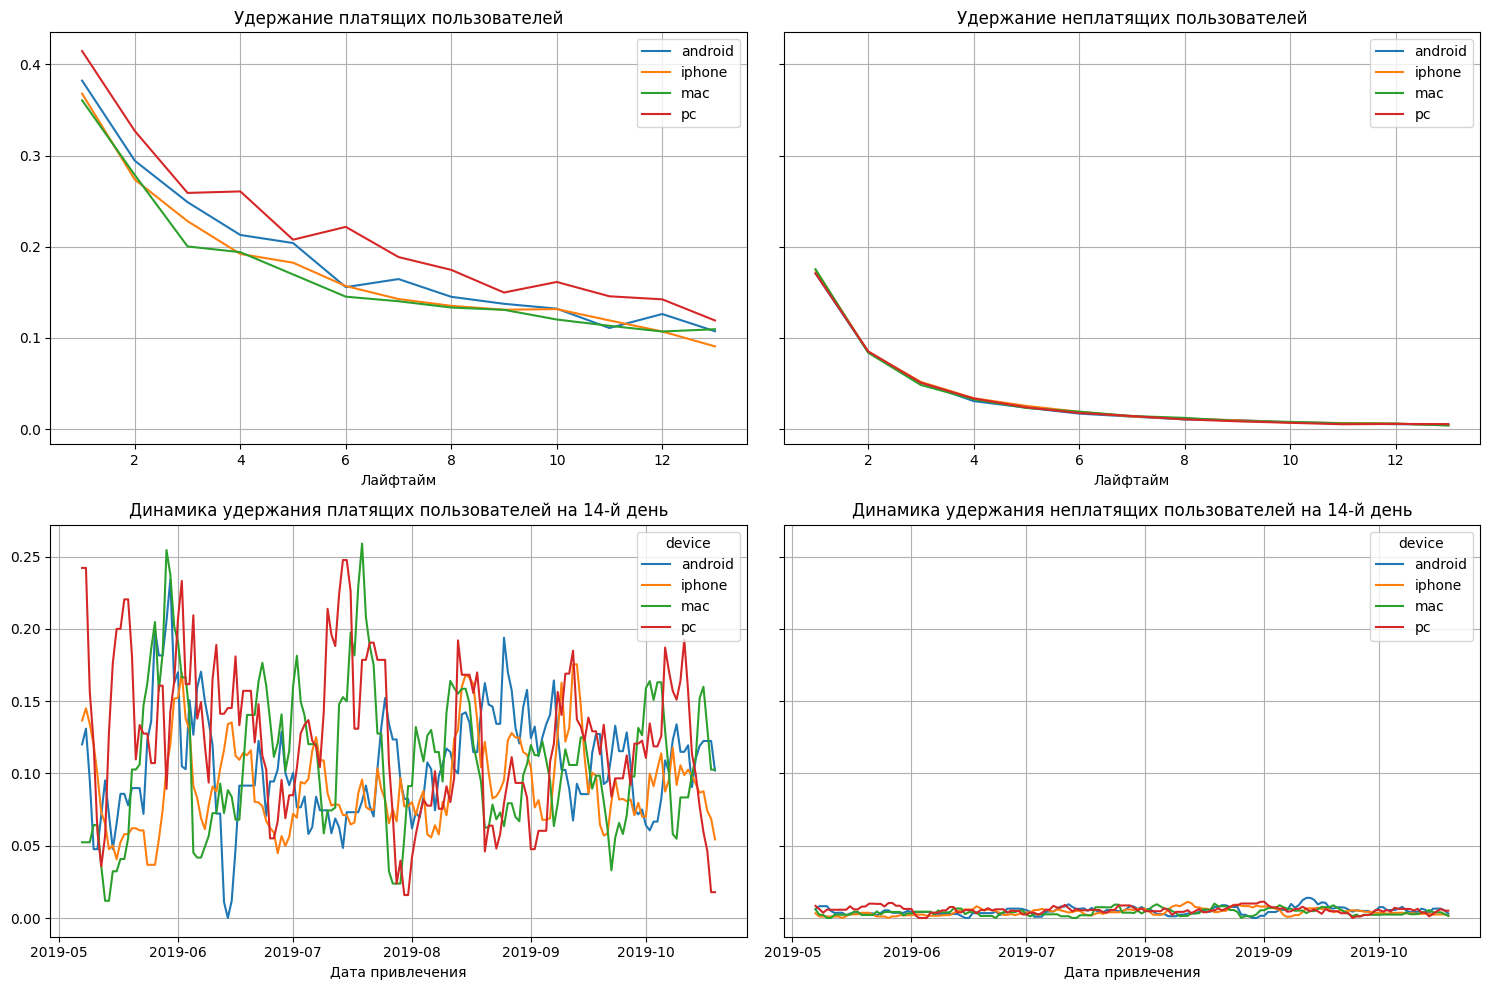

In [55]:
raw_ret, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_retention(retention, retention_history, horizon_days, window=7)

- Удержание неплатящих пользователей и динамика удержания по платформам не отличается
- В среднем удержание пользователей `pc` выше конкурентов, конкуренты примерно на одном уровне
- В динамике удержания картина схожая, однако, случаются периодические выбросы: конкуренты превосходят, либо сравниваются с платформой `pc` в некоторых когортах

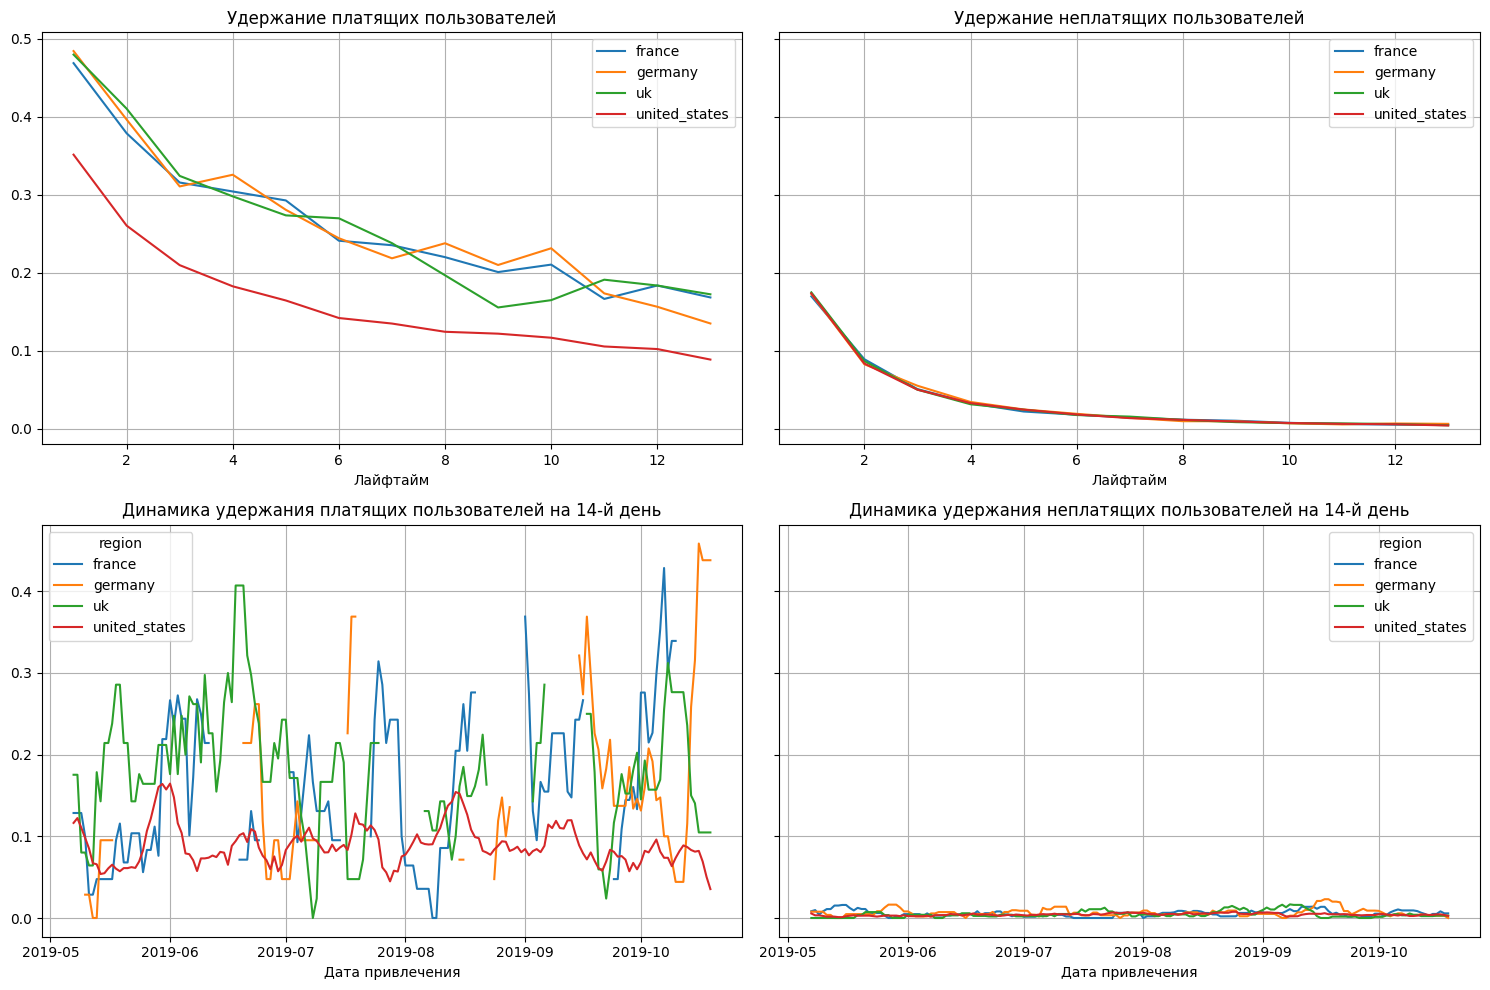

In [56]:
raw_ret, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_retention(retention, retention_history, horizon_days, window=7)

- Удержание неплатящих пользователей по странам выглядит идентично
- Хуже всего удерживаются пользователи из США, тот же вывод можно сделать и в динамике удержания
- Пользователи из Европы удерживаются примерно одинаково

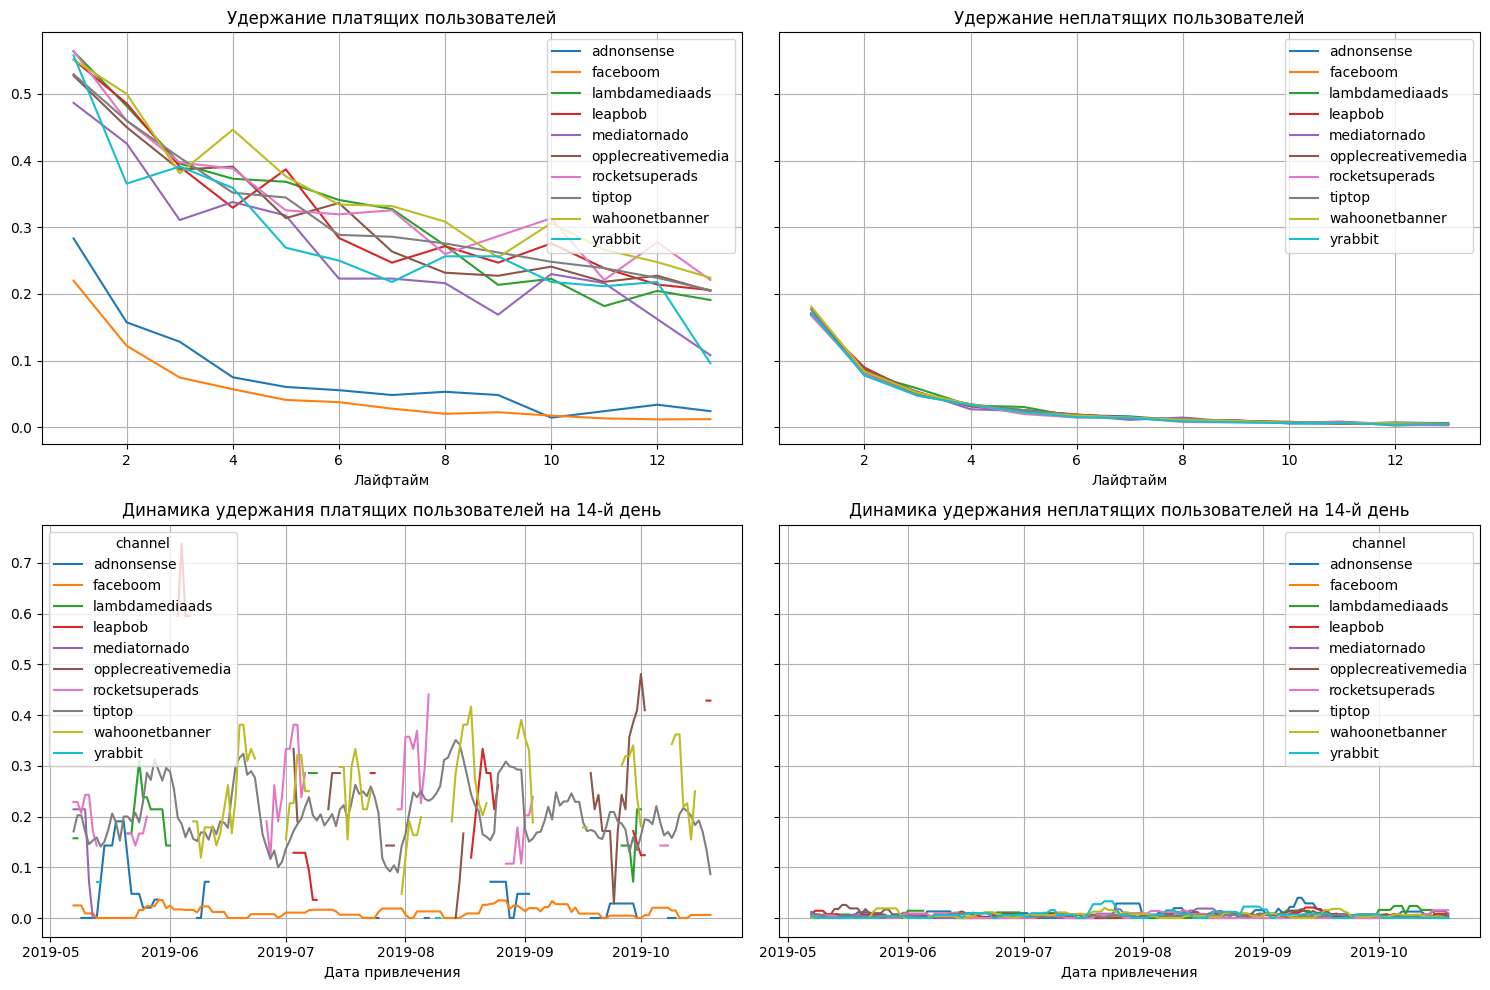

In [57]:
raw_ret, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_retention(retention, retention_history, horizon_days, window=7)

- Удержание неплатящих пользователей по источникам трафика идентично
- Хуже всего удерживаются пользователи из `faceboom` и `adnonsense`, остальные источники располагаются в общем семействе кривых

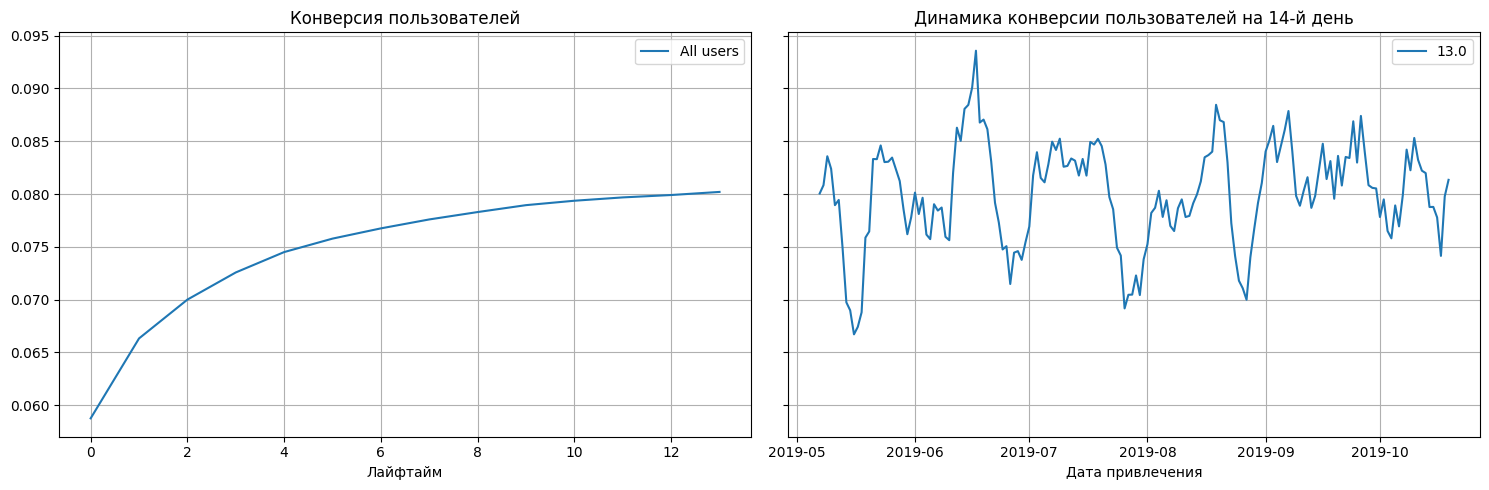

In [58]:
raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=7)

- График конверсии имеет ожидаемый вид с непрерывным ростом
- Динамика конверсии за две недели демонстрирует сезонность с периодическими снижениями и возрастаниями; колебания происходят около значения `0.08`

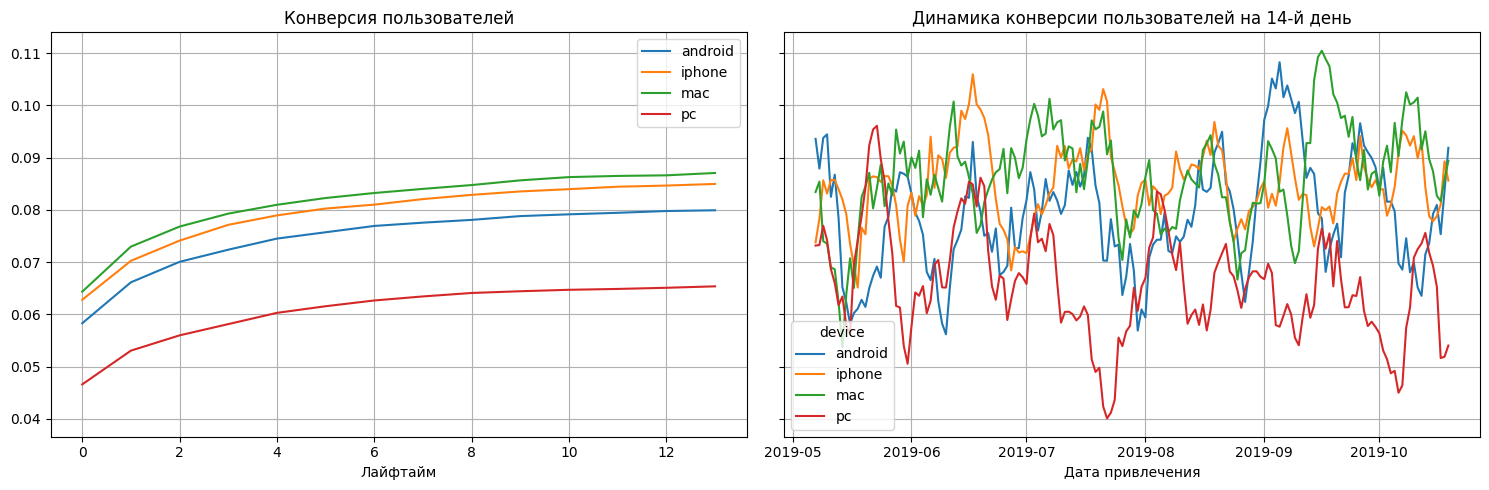

In [59]:
raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=7)

- Хуже всего конверсия пользователей `pc`, лучше всего у пользователей `mac` и `iphone`, `android` занимает промежуточное положение, ближе к лидерам
- Соотношение сохраняется и в динамике

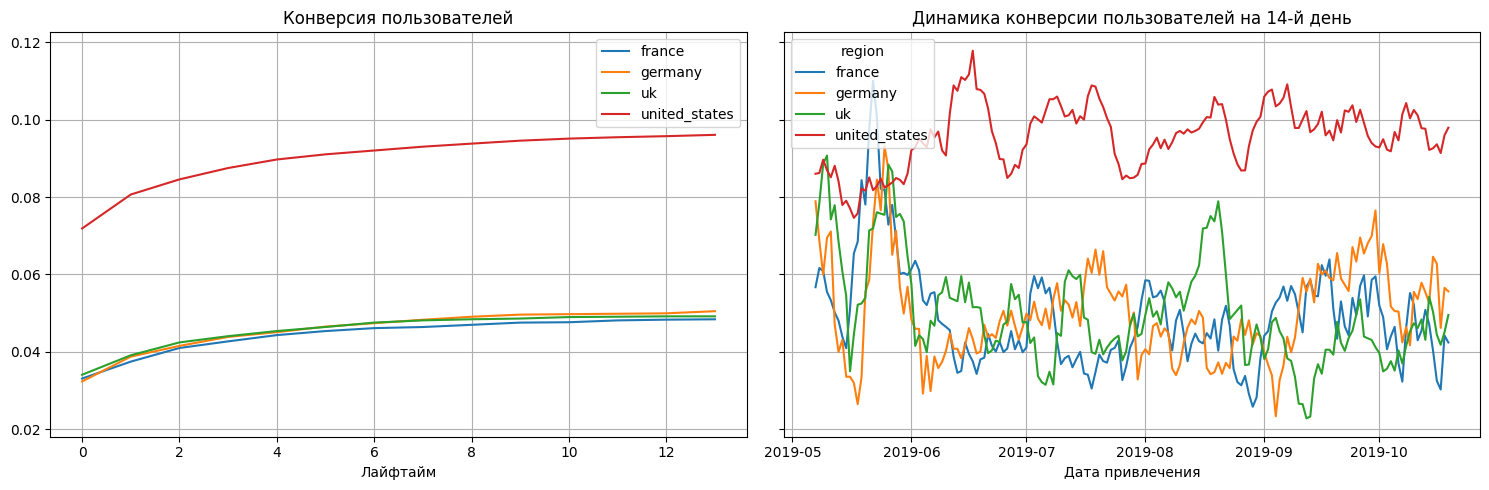

In [60]:
raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=7)

- Лучше всего с большим отрвывом от конкурентов конвертируются пользователи из США
- Европейские страны примерно на одном уровне
- В динамике ситуация сохраняется

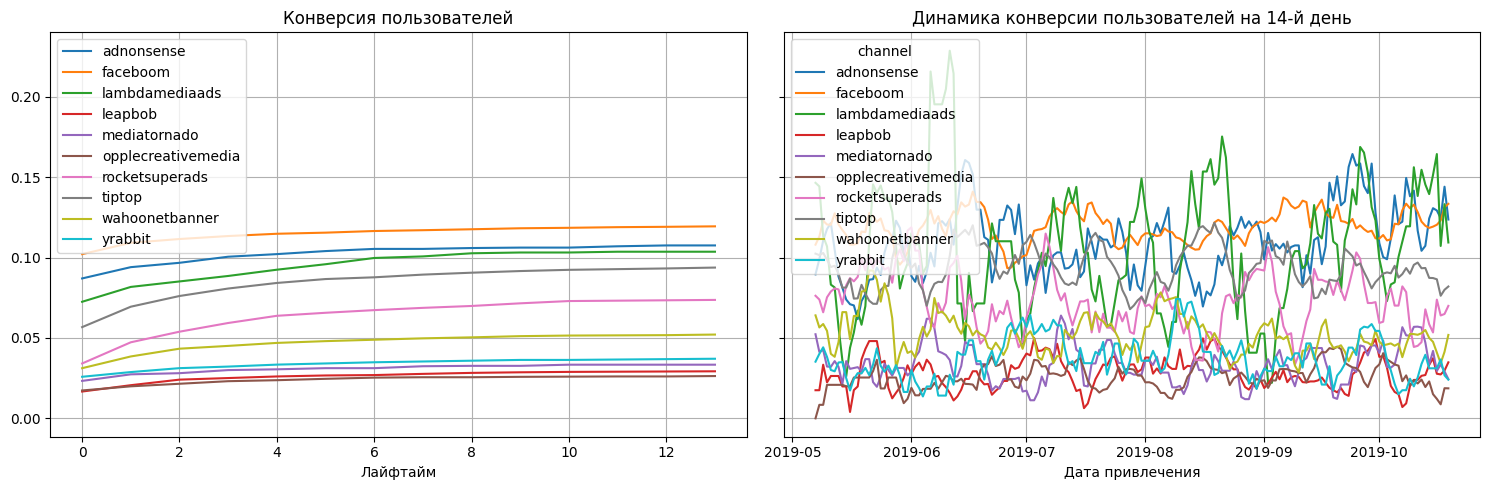

In [61]:
raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=7)

- Самая высокая конверсия у пользователей `faceboom`, `adnonsense` и `lambdamediaads`
- Самая низкая конверсия у пользователей `opplecreativemedia`, `leapbob` и `yrabbit`

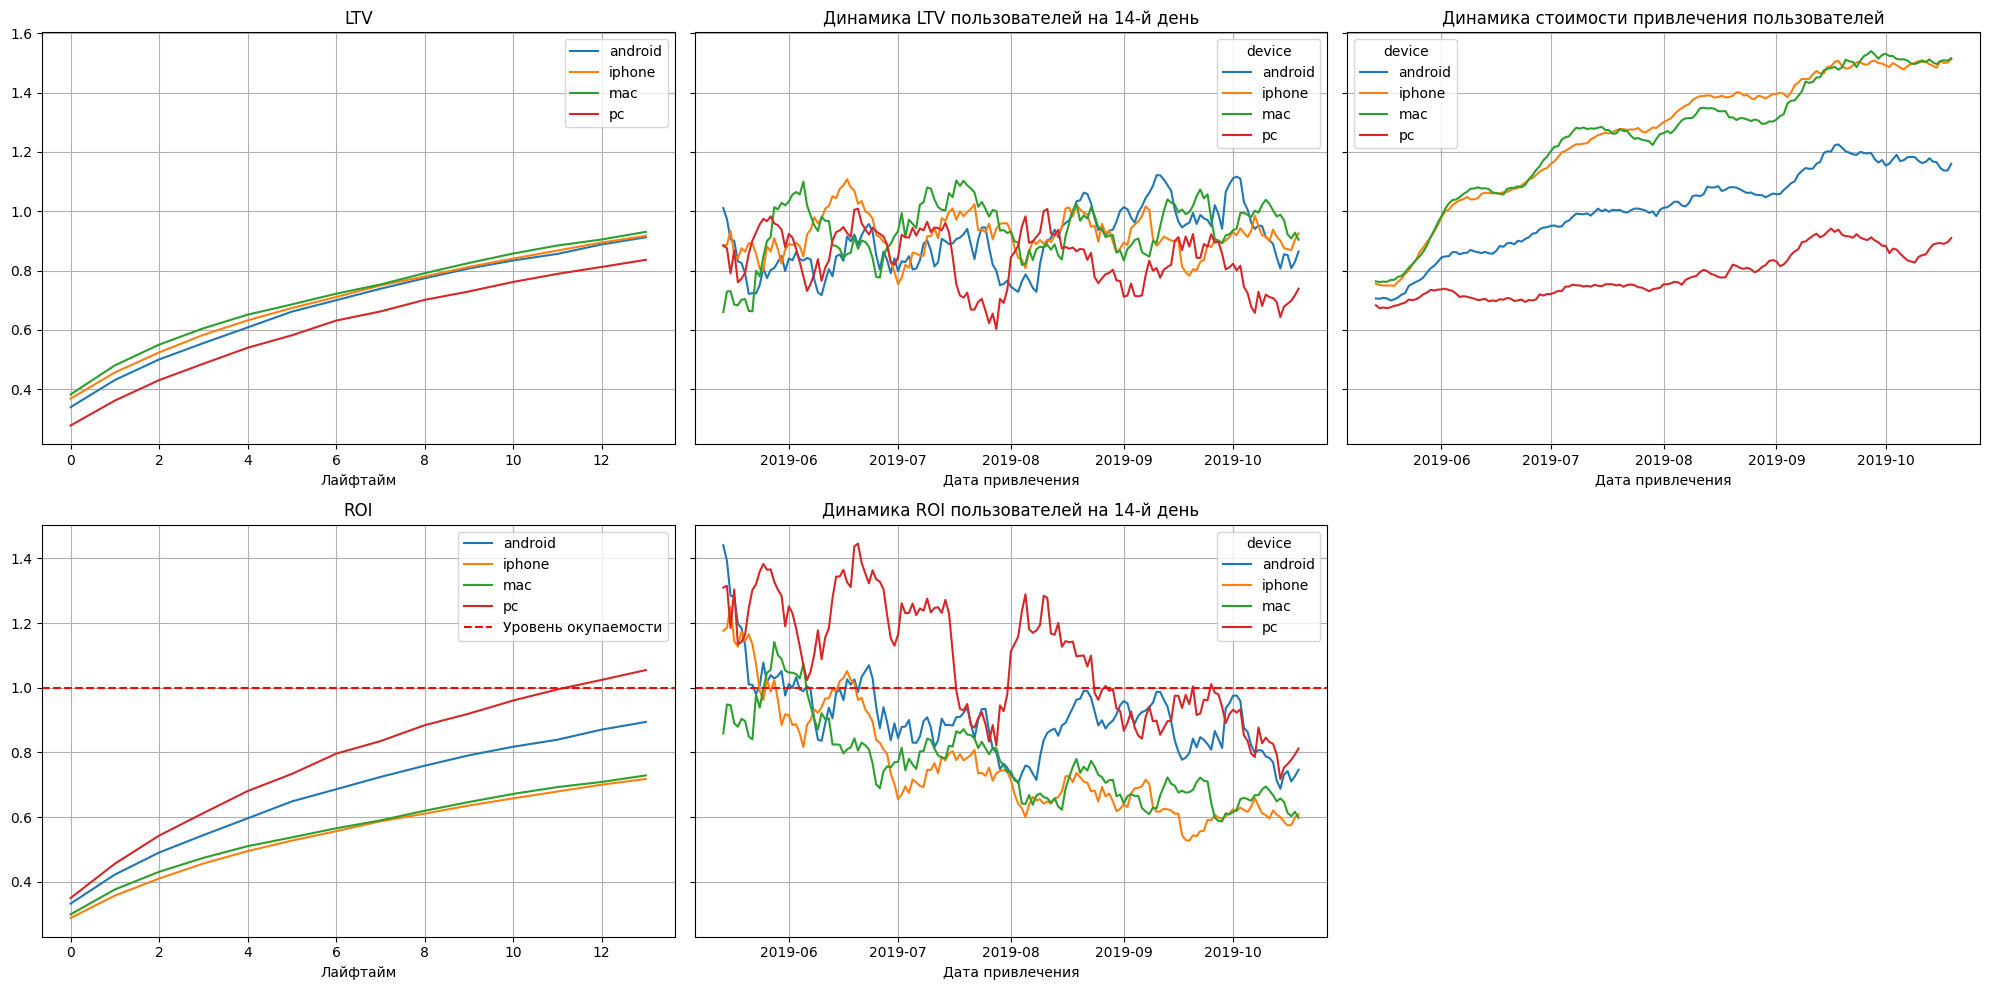

In [62]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Проверим источники трафика новых пользователей для разных платформ

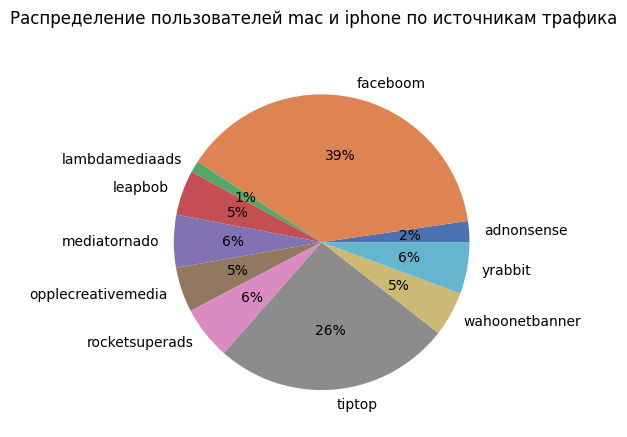

In [63]:
(profiles.query('device in ["mac", "iphone"]')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%', 
               colors = colors,
               title='Распределение пользователей mac и iphone по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

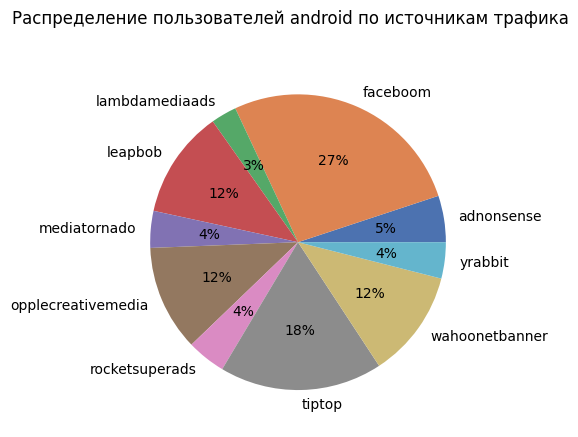

In [64]:
(profiles.query('device == "android"')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%',
               colors = colors,
               title='Распределение пользователей android по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

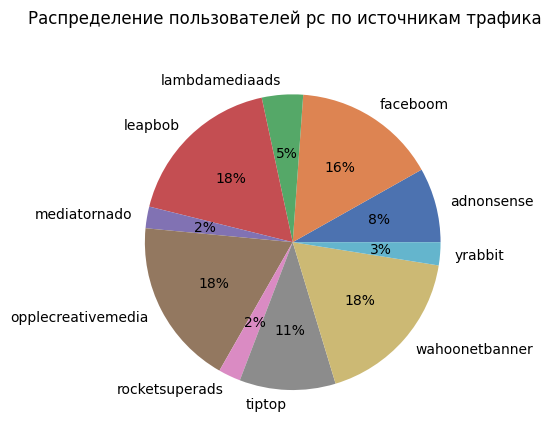

In [65]:
(profiles.query('device == "pc"')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%', 
               colors = colors,
               title='Распределение пользователей pc по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

Снижение популярности `tiptop` и `faceboom` у пользователей приводит к снижению `CAC`

- `LTV` пользователей всех платформ растет примерно в одной динамике, при этом `pc` ниже всех оставшихся платформ на протяжении всего двухнедельного лайфтайма, `android` `iphone` и `mac` примерно на одном уровне
- Динамика `LTV` двух недель хорошо сочетается с графиком `LTV` -- платформа `pc` стабильно ниже конкурентов, периодически отрыв усиливается (конец июля, начало сентября)
- Средняя стоимость привлечения пользователей всех платформ растет с течением времени, быстрее всего она растет для `mac` и `iphone`, медленнее всего для `pc`; наиболее дешево обошлись пользователи платформы `pc`, самыми дорогими оказались платформы `mac` и `iphone`, а пользователи `android` заняли промежуточное положение
- Пользователи `pc` окупаются в среднем к концу двух недель
- Пользователи `android`, `mac` и `iphone` убыточны для приложения -- `ROI` меньше единицы по прошествии двух недель; это связано с большей популярностью `tiptop` у пользователей этих платформ в сравнении с пользователями `pc`
- Динамика `ROI` двух недель показывает снижение экономической эффективности для всех когорт с приближением к текущей дате
- Когорты `pc` начала сентября и далее перестают окупаться

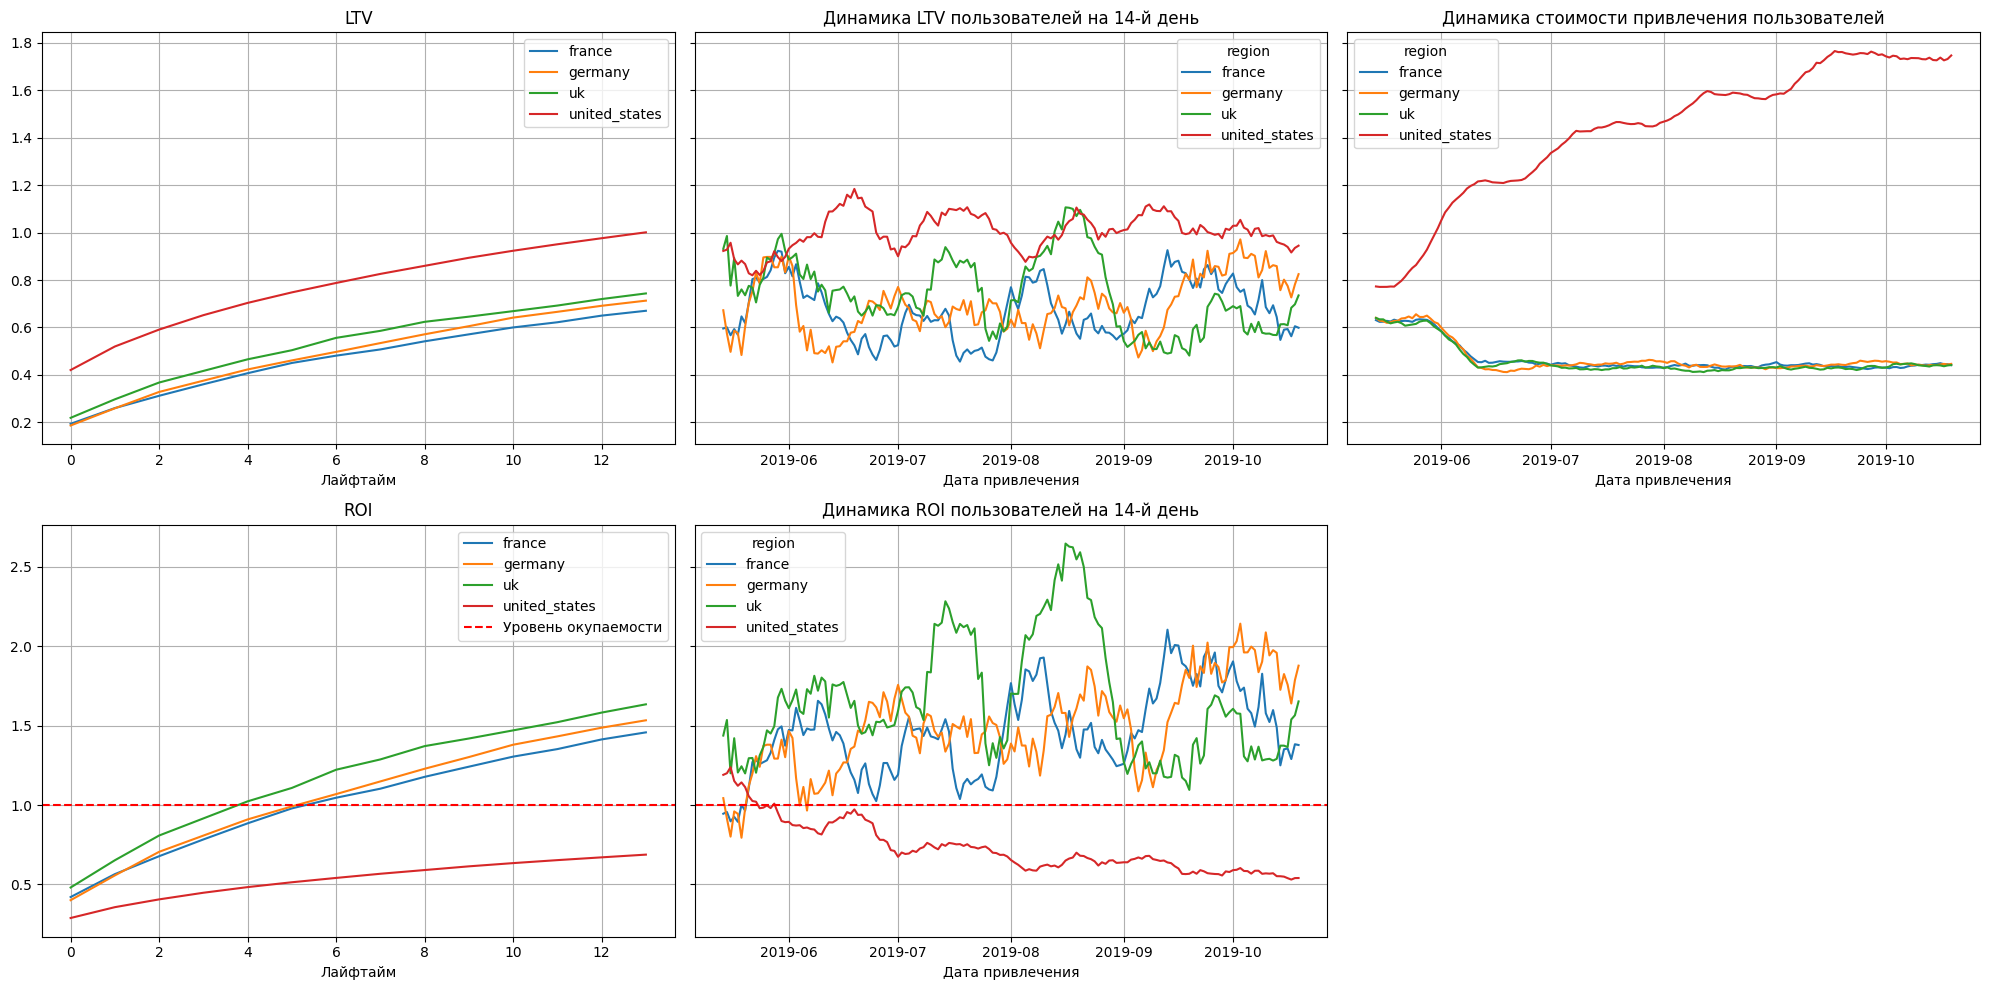

In [66]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Проверим, какие источники трафика для пользователей из США

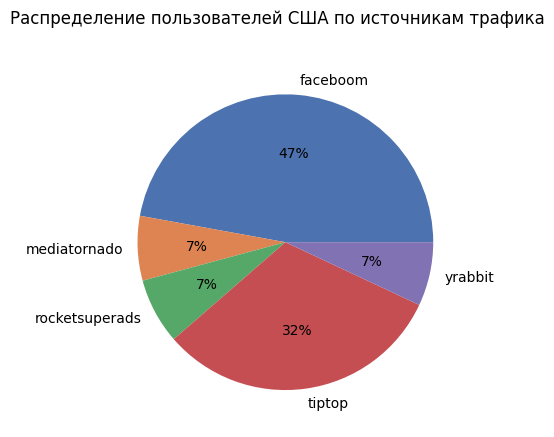

In [67]:
(profiles.query('region == "united_states"')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%',
               colors = colors,
               title='Распределение пользователей США по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

Несмотря на то, что большинство пользователей из США пришли из `faceboom`, влияние `tiptop` велико: 32 %

Проверим, какие источники трафика для пользователей из Великобритании

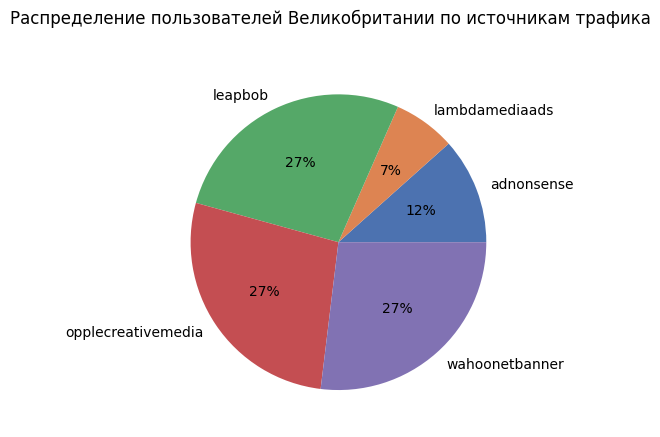

In [68]:
(profiles.query('region == "uk"')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%', 
               colors = colors,
               title='Распределение пользователей Великобритании по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

В Великобритании не привлекались пользователи `tiptop`, в этом и причина низкого `CAC` для этого региона; для гарантии проверим распределение для Германии

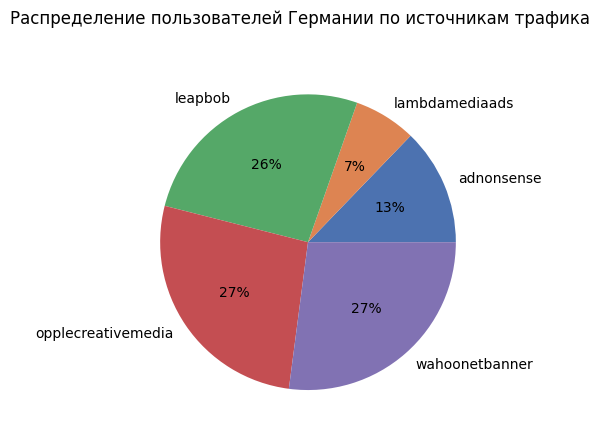

In [69]:
(profiles.query('region == "germany"')
         .groupby('channel')['user_id']
         .count()
         .plot(kind='pie', 
               subplots=True, 
               autopct='%1.0f%%',
               colors = colors,
               title='Распределение пользователей Германии по источникам трафика')
)
plt.ylabel(None)
plt.show;
plt.draw()
plt.pause(0.001)

Практически идентичная картина с Великобританией, гипотеза подтвердилась

- По `LTV` и динамике `LTV` в явных лидерах пользователи из США; Германия, Великобритания и Франция примерно на одном уровне, однако Франция несколько проигрывает конкурентам
- Динамика стоимости привлечения пользователей из Германии, Великобритании и Франции относительно стабильна после падения в середине июня: стоимость находится примерно на одном уровне; пользователи из США гораздо дороже конкурентов с резким ростом в конце мая-начале июня с последующим постепенным ростом -- это влияние платформы `tiptop` , которая популярна в США, но не популярна в Европе
- Очевидно влияние стоимости привлечения пользователей на `ROI` и его динамику, несмотря на низкие значения `LTV` пользователей из Европы, они стабильно окупаются уже на пятый-шестой день лайфтайма, а пользователи из США в сраднем не окупаются за две недели; пользователи из США окупались только до конца мая -- до взрывного роста их `CAC`
- Значение `ROI` двух недель для европейских пользователей достигает значений на уровне `150 %`

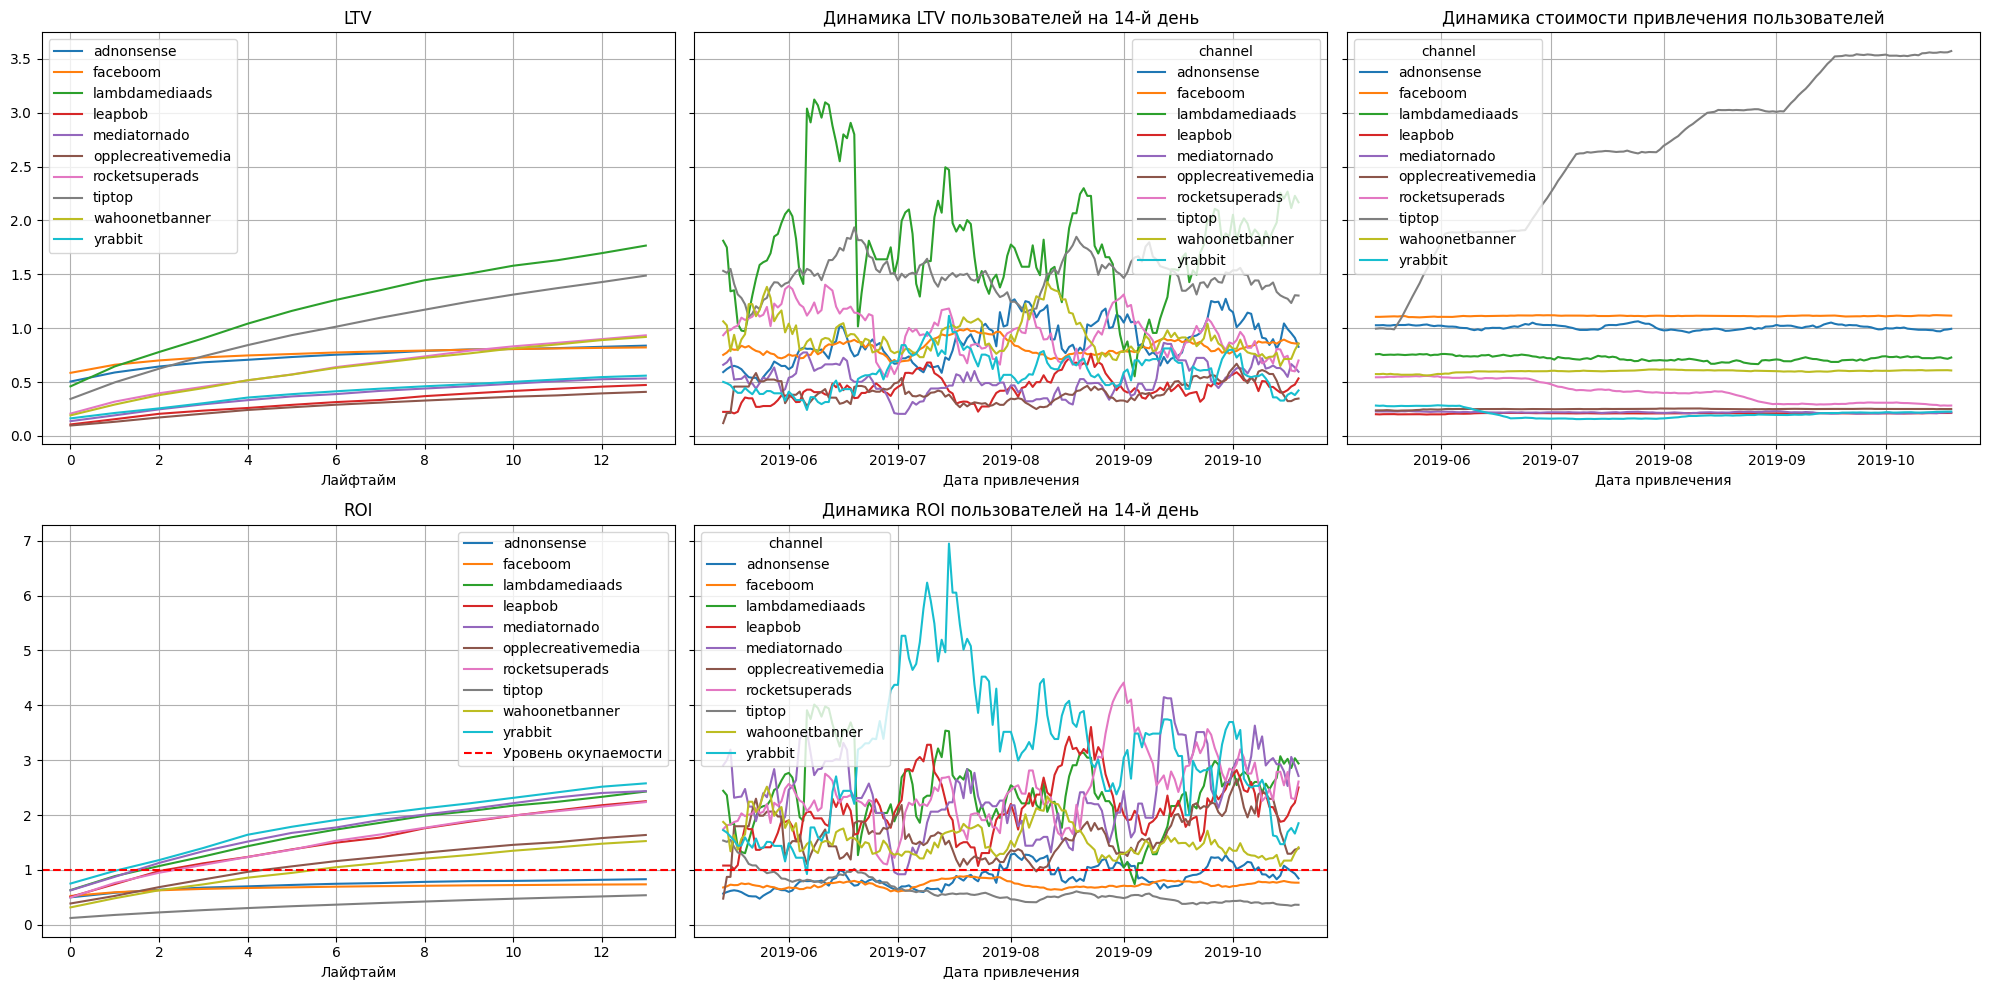

cohort_size   cac   0.0   1.0   2.0   3.0   4.0   5.0  \
channel                                                                     
yrabbit                    4102 0.217 0.752 0.983 1.179 1.400 1.641 1.787   
mediatornado               4167 0.219 0.628 0.875 1.127 1.341 1.517 1.675   
lambdamediaads             2056 0.727 0.633 0.887 1.071 1.245 1.432 1.596   
leapbob                    8103 0.210 0.510 0.741 0.979 1.121 1.236 1.374   
rocketsuperads             4251 0.417 0.497 0.763 0.949 1.092 1.235 1.368   
opplecreativemedia         8139 0.250 0.389 0.527 0.687 0.827 0.965 1.065   
wahoonetbanner             8082 0.602 0.318 0.484 0.630 0.737 0.859 0.946   
adnonsense                 3702 1.008 0.501 0.584 0.639 0.678 0.701 0.727   
faceboom                  27544 1.113 0.526 0.594 0.629 0.655 0.671 0.683   
tiptop                    18498 2.758 0.125 0.180 0.226 0.268 0.305 0.339   

                     6.0   7.0   8.0   9.0  10.0  11.0  12.0  13.0  
channel                                                             
yrabbit            1.910 2.022 2.123 2.213 2.314 2.414 2.516 2.578  
mediatornado       1.774 1.911 2.009 2.107 2.217 2.321 2.403 2.437  
lambdamediaads     1.736 1.859 1.987 2.070 2.172 2.242 2.332 2.429  
leapbob            1.498 1.590 1.760 1.877 1.988 2.085 2.179 2.252  
rocketsuperads     1.531 1.646 1.768 1.893 1.992 2.071 2.153 2.237  
opplecreativemedia 1.161 1.239 1.315 1.388 1.457 1.507 1.581 1.637  
wahoonetbanner     1.050 1.127 1.205 1.272 1.350 1.411 1.478 1.526  
adnonsense         0.748 0.762 0.783 0.796 0.801 0.809 0.821 0.831  
faceboom           0.696 0.705 0.712 0.719 0.724 0.729 0.734 0.738  
tiptop             0.368 0.398 0.425 0.452 0.476 0.497 0.518 0.540

In [70]:
raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)
roi.sort_values(by=13, ascending=False)

- Лучше всего показатель `LTV`, как и его динамика у канала `lambdamediaads`, на втором месте `tiptop`, хуже всего показатель у `opplecreativemedia`
- Почти у всех источников трафика динамика `CAC` практически постоянная, у `rocketsuperads` и `yrabbit` она даже падает, при этом источник `tiptop` постоянно повышает стоимость привлечения нового пользователя: с самого начала этот показатель был почти самым большим, а со временем вырос до огромных значений в сравнении с конкурентами -- необходимо уточнить, с чем это связано? Растет `CPM` / `CPC`? Прошлая рекламная кампания еще активна, а мы начинаем новую? Для точного ответа нужно понимать детали рекламных кампаний с этим источником
- Показатель `ROI` демонстрирует неэффективность привлечения по каналам `tiptop`, `faceboom` и `adnonsense` -- в среднем пользователи из этих источников не окупаются за двухнедельный лайфтайм; в динамике источник `tiptop` окупался до конца мая, но не позднее; `adnonsense` периодически пересекает границу рентабельности (в начале августа, сентября и октября)
- Наибольшую инвестиционную эффективность демонстрируют пользователи из каналов `yrabbit`, `mediatornado` и `lambdamediaads` -- пользователи из этих каналов окупаются в среднем уже на третий день

Гипотеза того, что пользователи `tiptop` конвертируются в среднем лучше остальных, подтвердилась

Как соотносится количество новых пользователи из `tiptop` с объемом инвестиций в рекламу по этому каналу?

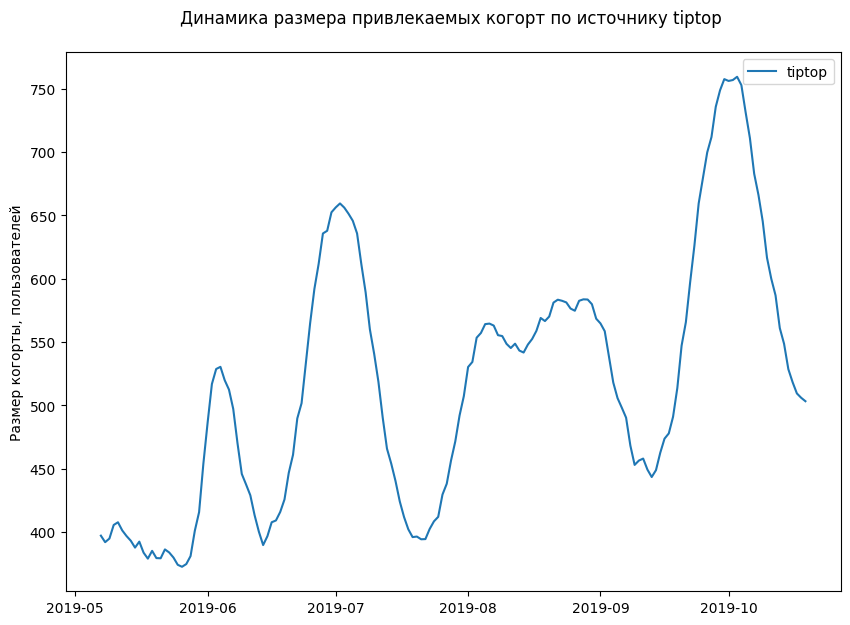

In [71]:
visits_tiptop = visits.query('channel == "tiptop"')

raw_ret, retention_tiptop, retention_history_tiptop = get_retention(
    profiles,
    visits_tiptop,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)


tiptop_pivot = (
    retention_history_tiptop.reset_index()
    .pivot_table(index='dt', 
                 values='cohort_size', 
                 aggfunc='sum'))

tiptop_pivot = filter_data(tiptop_pivot, 7)

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

ax.plot(tiptop_pivot.index, tiptop_pivot['cohort_size'], label = "tiptop")
    
ax.set_title('Динамика размера привлекаемых когорт по источнику tiptop \n')
ax.set_ylabel('Размер когорты, пользователей')

ax.legend()
plt.show;
plt.draw()
plt.pause(0.001)

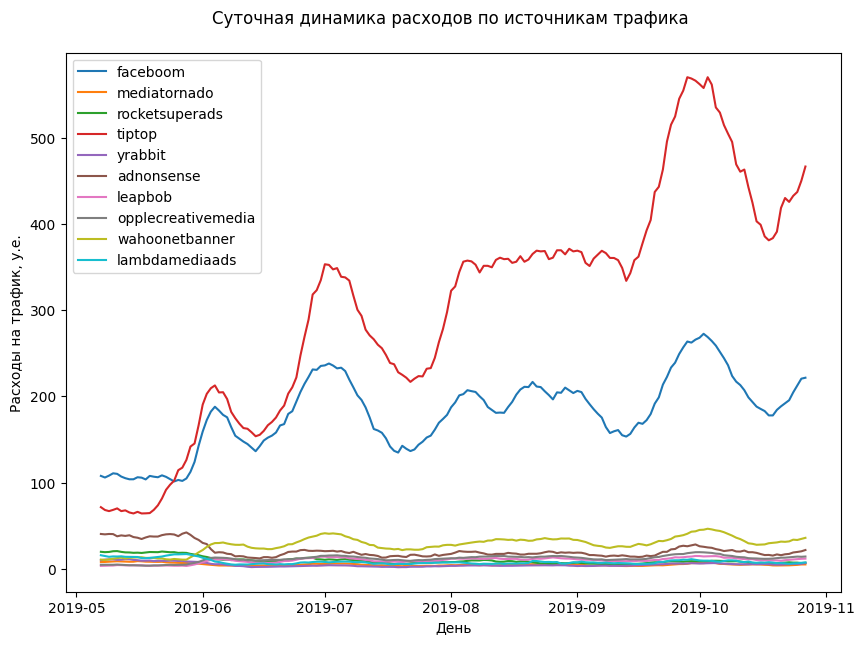

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

for i in costs_fig['channel'].unique():
    pivot_i = (costs_fig.query('channel == @i')
                 .pivot_table(index='dt', 
                              values='costs', 
                              aggfunc='sum'))
    pivot_i = filter_data(pivot_i, 7)
    ax.plot(pivot_i.index, pivot_i['costs'], label = i)
    
ax.set_title('Суточная динамика расходов по источникам трафика \n')
ax.set_ylabel('Расходы на трафик, у.е.')
ax.set_xlabel('День')
ax.legend()
plt.show;
plt.draw()
plt.pause(0.001)

- В какой-то мере привлечение новых пользователей соотносится с вливаниями в рекламу в `tiptop`, при этом смущает период начала августа-начала сентября: траты на рекламу сопоставимы с прошлым пиком или выше, а количество привлекаемых пользователей значительно ниже
- Рабочая гипотеза -- стоимость рекламы в `tiptop` повышалась, либо в конце мая была изменена модель оплаты: например ранее была `CPM`, а после стала `CPC`

### **Вывод**

- В среднем маркетинговые инвестиции не окупаются -- за рассматриваемый период в течение двухнедельного лайфтайма `ROI` ниже единицы
- Динамика `ROI` двух недель показывает, что в мае маркетинговые инвестиции окупались, как и в середине июня, но тренд, намеченный в начале июня сохранился и продолжился с конца июня -- инвестиции стали убыточны; выход в плюс в середине июня объясняется сезонностью -- в этот период динамика `LTV` также демонстрирует рост
- Пользователи `android`, `mac` и `iphone` убыточны для приложения -- `ROI` меньше единицы по прошествии двух недель; это связано с большей популярностью `tiptop` у пользователей этих платформ в сравнении с пользователями `pc`
- Динамика `ROI` двух недель показывает снижение экономической эффективности для всех когорт с приближением к текущей дате
- Когорты `pc` начала сентября и далее перестают окупаться
- Из четырех стран в выборке не окупаются только пользователи из США: в Европе `tiptop` не популярен, поэтому нет негативного влияния на `CAC` европейских пользователей
- Кластеризация по источникам трафика показала неэффективность привлечения по каналам `tiptop`, `faceboom` и `adnonsense` -- в среднем пользователи из этих источников не окупаются за двухнедельный лайфтайм; в динамике это также стабильно, независимо от даты привлечения пользователей -- они не окупаются за две недели
- Ключевое негативное влияние канала `tiptop` -- колоссальный рост `CAC` с течением времени, необходимо уточнить детали рекламных кампаний: каким образом происходит оплата? 
- Достаточно велико влияние канала `faceboom` на убыточность приложения: пользователи, привлеченные по этому каналу не окупаются, но маркетинговые траты на этот канал составляют примерно треть всех трат за период
- Рекомендуется отказаться от размещения в `tiptop` и `faceboom`, вместо этого стоит рассмотреть размещение в `yrabbit`, `mediatornado`, `lambdamediaads`, `leapbob`, `rocketsuperads`

## **Общий вывод**

**Предобработка данных**


- Названия столбцов и текстовые поля приведены к нижнему регистру, пробелы заменены на нижнее подчеркивание
- Пропусков данных не обнаружено
- Типы данных для столбцов с датой приведены в соответствие
- Дубликаты всех видов не обнаружены
- Аномальные значения не обнаружены

**Исследовательский анализ данных**


- Привлеченные пользователи живут в США, Великобритании, Франции и Германии, самые качественные по конверсии пользователи из США; наименее качественные из Франции
- Всего в выборке четыре типа устройств, с которых заходили в приложение: `iphone`, `android`, `mac` и `pc`, в абсолютном выражении у самых качественных по конверсии пользователей `iphone`, а в относительном -- `mac`, наименее качественные пользователи `pc`
- Больше всего пользователей привлечены в приложение органически, при этом у органиков самая низкая доля платящих пользователей; наиболее качественных пользователей по конверсии привлек источник `faceboom`

**Анализ маркетинга**


- За последние пять месяцев рекламный бюджет составил 106 тыс. у.е
- Примерно `83 %` всего бюджета потрачено на два источника трафика -- `tiptop` и `faceboom`, при этом чуть больше половины всех средств ушло на продвижение через `tiptop`
- Траты на все источники трафика можно назвать примерно постоянными в сравнении с тратами на `tiptop` -- этот источник трафика демонстрирует стремительный рост затрат в течение рассматриваемого периода
- Наибольшая средняя стоимость привлечения одного пользователя у источников `tiptop` и `faceboom`, при это для `tiptop` этот показатель в 2.5 раза выше в сравнении с `faceboom`
- Наименьшая средняя стоимость привлечения одного пользователя у источников `leapbob`, `mediatornado` и `yrabbit`
- В рейтинге источников трафика по конверсии пользователей с учетом `CAC`, требуемого для привлечения этих пользователей, `tiptop` и `faceboom` находятся в худшей половине, `tiptop` находится на последнем месте
- Необходимо уточнить: способны ли другие источники обеспечить необходимый приток пользователей?

**Оценка рентабельности рекламы**


- В среднем маркетинговые инвестиции не окупаются -- за рассматриваемый период в течение двухнедельного лайфтайма `ROI` ниже единицы
- Динамика `ROI` двух недель показывает, что в мае маркетинговые инвестиции окупались, как и в середине июня, но тренд, намеченный в начале июня сохранился и продолжился с конца июня -- инвестиции стали убыточны; выход в плюс в середине июня объясняется сезонностью -- в этот период динамика `LTV` также демонстрирует рост
- Пользователи `android`, `mac` и `iphone` убыточны для приложения -- `ROI` меньше единицы по прошествии двух недель; это связано с большей популярностью `tiptop` у пользователей этих платформ в сравнении с пользователями `pc`
- Динамика `ROI` двух недель показывает снижение экономической эффективности для всех когорт с приближением к текущей дате
- Когорты `pc` начала сентября и далее перестают окупаться
- Из четырех стран в выборке не окупаются только пользователи из США: в Европе `tiptop` не популярен, поэтому нет негативного влияния на `CAC` европейских пользователей
- Кластеризация по источникам трафика показала неэффективность привлечения по каналам `tiptop`, `faceboom` и `adnonsense` -- в среднем пользователи из этих источников не окупаются за двухнедельный лайфтайм; в динамике это также стабильно, независимо от даты привлечения пользователей -- они не окупаются за две недели
- Ключевое негативное влияние канала `tiptop` -- колоссальный рост `CAC` с течением времени, необходимо уточнить детали рекламных кампаний: каким образом происходит оплата? 
- Достаточно велико влияние канала `faceboom` на убыточность приложения: пользователи, привлеченные по этому каналу не окупаются, но маркетинговые траты на этот канал составляют примерно треть всех трат за период
 

**Причины неэффективности стратегии маркетинга**

- Ключевые направления размещения рекламы в текущей стратегии -- `tiptop`, на него ушла половина всех средств за рассматриваемый период, а также `faceboom` -- на него ушла треть всех средств периода
- Пользователи, привлеченные по этим каналам стабильно не окупаются
- Объемы вливания средств в `faceboom` были примерно на одном уровне
- Объемы вливания средств в `tiptop` в течение рассматриваемого периода значительно возрастали
- Пользователи `faceboom` обладают крайне низким удержанием, что вкупе с достаточно высоким `CAC` приводит к убыточности размещения, даже несмотря на самую лучшую конверсию по источникам трафика
- Удержание и конверсия пользователей `tiptop` средние или чуть выше среднего, но взрывной рост `CAC` привел к убыточности этого канала привлечения трафика
- Фокусировка рекламных инвестиций на крайне неэффективных источниках трафика привела к убыточности приложения


**Рекомендации**

- Рекомендуется отказаться от размещения в `tiptop` и `faceboom`
- Cледует уточнить причины бесконтрольного роста `CAC` для платформы `tiptop` -- происходило ли повышение цены размещения?
- Cтоит рассмотреть размещение в платформах `yrabbit`, `mediatornado`, `lambdamediaads`, `leapbob`, `rocketsuperads`, показавших себя как экономически наиболее удачные источники трафика для приложения